# 파이썬으로 배우는 기계학습
# Machine Learning with Python
**************

# 제 10-3강: 로지스틱 회귀 2


## 학습 목표
- 로지스틱 함수를 이해한다. 
- 로지스틱 회귀 비용함수(교차 엔트로피)를 이해한다.
- 로지스틱 회귀 신경망의 역전파를 계산한다.

## 학습 내용
- 로지스틱 함수 이해
- 로지스틱 회귀 비용함수(교차 엔트로피) 미분하기
- 로지스틱 회귀 신경망의 역전파 계산


# 제 11-1강: 로지스틱 회귀 3

## 학습 목표
- 교차 엔트로피 손실함수를 이해한다.  
- 로지스틱 회귀 신경망의 역전파 계산한다.
- 소프트맥스 활성화 함수를 이해한다.
- 로지스틱 회귀 신경망을 구현한다. 

## 학습 내용
- 교차 엔트로피 손실함수와 제곱 합 오차함수의 비교
- 로지스틱 회귀의 역전파를 행렬로 계산하기
- 소프트맥스 활성화 함수를 이해하기
- 로지스틱 회귀 신경망에 구현하여 적용하기


이번 강의에서는 XOR보다 좀 더 복잡한 자료를 가지고, 우리가 이미 만든 3층 신경망 NeuralNetwork 객체로 이항 분류를 먼저 시도합니다. 그 후에, 같은 자료에 대해 로지스틱 회귀 알고리즘을 사용해서 결과를 비교하고자 합니다.  우리가 사용할 꽃 모앙의 자료는 [Andrew Ng 교수의 강의](https://www.coursera.org/learn/neural-networks-deep-learning/lecture/7dP6E/deep-l-layer-neural-network)에서 가져왔습니다. 

## 1. 학습자료의 준비

기계학습의 첫번째 관문은 자료 수집과 기계학습에 적용 가능하도록 전처리하는 과정입니다. 우리가 사용할 가상적인 학습자료가 준비되어 있으며, 우리는 단순히 그 자료를 읽어온다고 가정합니다. 학습자료를 읽은 온 후에는 시각화하여 자료의 특성을 파악합니다. 이 자료를 이항 분류(두 개의 클래스로 분류)할 수 있는 신경망을 구축하는 것이 우리의 목표입니다. 

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Our own private imports
import imp
import joy
imp.reload(joy)
np.random.seed(1)   # a good practice for reproducibility and debugging

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


다음 코드는 인위적으로 만든 꽃 모양의 입력자료를 읽고 $X, Y$에 저장하고 두 개의 클래스를 시각화합니다.  주황색은 클래스 0, 푸른색은 클래스 1을 나타냅니다.  

X.shape = (2, 400) Y.shape = (1, 400), Examples = 400


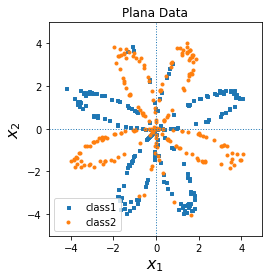

In [2]:
X, Y = joy.planar_data()       
m = X.shape[1]                  # training set size
print ('X.shape = {} Y.shape = {}, Examples = {}'.
       format(X.shape, Y.shape, m))
assert(m == Y.shape[1])

joy.plot_xyw(X.T, Y.squeeze(), title="Plana Data")  
#plt.scatter(X[0, :], X[1, :], c=Y.squeeze(), s=40, cmap=plt.cm.Spectral); 

입력 자료 $X$는 각 자료의 특성이 $(x_1, x_2)$로 구성되어 있으며, 총 자료$^{examples}$의 갯수 $m = 400$이며, 형상은 $(2, 400)$입니다.  그러므로, $Y$는 각 자료에 대한 클래스 레이블이며, 그 크기 역시 400이 되어야 합니다. 따라서 다음과 `assert`를 사용하여 두 자료 즉 $X, Y$가 함께 사용할 수 있는 자료인지 확인합니다. 한 가지 유의할 것은 $Y$의 형상은 $(1, 400)$이며, $(400,)$가 아닙니다.  

`assert(m == Y.shape[1])`


시각화 함수 중에 하나인 `joy.plot_xyw()`함수는 $X, Y$를 각각 행$^{row}$중심으로 된 자료를 받기 때문에 원래 $X, Y$를 `(400, 2), (400,)` 형상으로 조정하여 호출해야 합니다.  $X, Y$를 각각 전치$^{transpose}$하거나 `squeeze()`함수를 사용하여 형상을 전환하였습니다.   

`joy.plot_xyw(X.T, Y.squeeze(), title="Plana Data")`  

또 `scatter( )` 함수로 시각화할 수도 있습니다. 참고로 `Y.squeeze()`는 현재의 Y의 형상 `(1,400)`을 `(400,)`으로 변환하며, `reshape()`을 사용한다면 `Y.reshape(Y.shape[1])`으로 코딩합니다.  

```
plt.scatter(X[0, :], X[1, :], c=Y.squeeze(), s=40, cmap=plt.cm.Spectral); 
```

In [3]:
assert(m == Y.shape[1])

__JoyQuiz__: 우리가 다루고 있는 클래스 레이블 `Y.shape[1]`의 값은 무엇입니까? 



## 2.  Joy.NeuralNetwork 클래스

우리가 이미 지난 강의에서 joy.NeuralNetwork 신경망을 개발하여 XOR 분류 문제에 사용해 보았습니다.  이번에는 같은 신경망을 사용하여, 좀 더 복잡한 꽃 모양 자료를 이진 분류하는데 사용해 보려고 합니다. 

joy 모듈의 `NeuralNetwork` 클래스의 객체를 만들어 냈으며,`nn`로 이름하였습니다.  `NeuralNetwork` 클래스에 정의되어 있는 `fit()` 메소드를 사용해 학습자료를 훈련시킵니다. 

이항 분류가 끝난 후에 두 클래스를 분류한 결과를 시각화 하고 분류의 정확도를 계산해 보았습니다. 

Text(0.5,1,'Hidden layer neurons=3, accuracy=72.99')

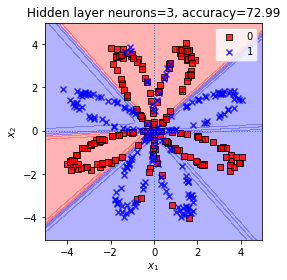

In [4]:
# Train the linear regression classifier
n_h = 3   # number of neuron in hidden layer
net_arch=[2, n_h, 1]
nn = joy.NeuralNetwork(net_arch, eta = 0.1, epochs=100)
nn.fit(X, Y)                    # train the net

# Plot the decision boundary 
joy.plot_decision_regions(X.T, Y, nn)

yhat = nn.predict(X.T)
accuracy = float(np.dot(Y, yhat.T) + np.dot(1 - Y, 1 - yhat.T))/Y.size * 100
plt.title('Hidden layer neurons={}, accuracy={}'.format(n_h, np.round(accuracy,2)))

## 뉴론의 수와 예측 정확도

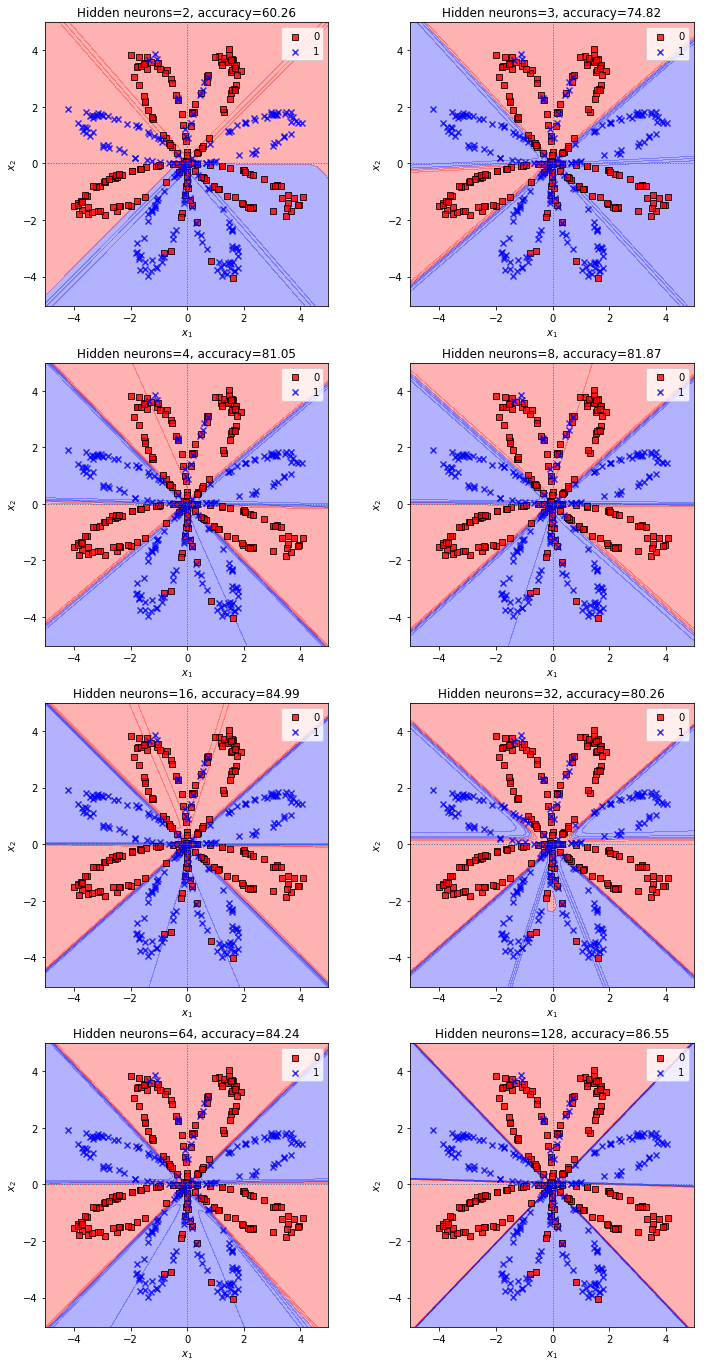

In [5]:
plt.figure(figsize=(12, 24))
accuracy = []
number_of_neurons = [2, 3, 4, 8, 16, 32, 64, 128]
for i, n_h in enumerate(number_of_neurons):
    net_arch = [2, 1]
    net_arch.insert(1, n_h)
    nn = joy.NeuralNetwork(net_arch, eta = 0.1, epochs=200)
    nn.fit(X, Y)               
    
    plt.subplot(4, 2, i+1)
    joy.plot_decision_regions(X.T, Y, nn)
    yhat = nn.predict(X.T)
    cost = float(np.dot(Y, yhat.T) + np.dot(1 - Y, 1 - yhat.T))
    accuracy.append(cost/Y.size * 100)
    plt.title('Hidden neurons={}, accuracy={}'
                  .format(n_h, np.round(accuracy[i],2)))

위의 시각화 한 결과를 관찰해 보면, 처음에는 뉴론의 수가 증가함에 따라 분류 정확도가 급격히 증가합니다. 그러나, 어떤 한계에 도달하면 뉴론의 수가 증가할지라도 정확도가 증가하지 않을 뿐만 아니라 과대적합과 유사한 현상이 일어납니다. 

이러한 현상을 좀 더 관찰하기 위해 은닉층의 노드 수의 변화에 따른 정확도를 좀 더 확장해서 다음과 실험을 해보면, 신경망의 불안정성이 나타나기도 합니다. 

이런 경우에는 신경망의 하이퍼 파라미터 중에 하나인 학습률을 0.1보다 낮은 값을 사용하여 가중치의 조정이 급격하지 않도록 하는 방법도 시도해볼 만 할 것입니다. 

이러한 인공신경망의 불안정성을 줄이기 위해 많은 연구가 진행되고 있습니다. 그래서, 이번 강의에서는 새로운 오차함수와 활성화함수를 사용하여 좀 더 나은 안정적인 분류와 반복 회수를 줄일 수 있는 시도해보고자 합니다. 

X.shape = (2, 400), Y.shape = (1, 400), samples = 400
Processing different number of neurons cases ......................................................................................................

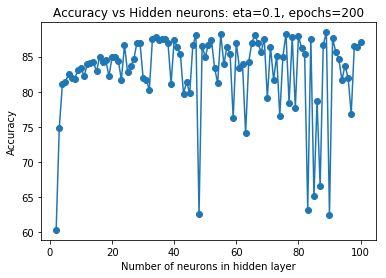

In [5]:
import joy
import numpy as np

X, Y = joy.planar_data()       
print ('X.shape = {}, Y.shape = {}, samples = {}'.format(X.shape, Y.shape, X.shape[1]))
assert(X.shape[1] == Y.shape[1])    # training set sample size

accuracy = []
number_of_neurons = [n for n in np.arange(2, 101)]
print('Processing different number of neurons cases ...', end='')
for i, n_h in enumerate(number_of_neurons):
    print('.', end='')
    net_arch = [2, 1]
    net_arch.insert(1, n_h)
    nn = joy.NeuralNetwork(net_arch, eta = 0.1, epochs=200)
    nn.fit(X, Y)                    # train the net
    yhat = nn.predict(X.T)
    accuracy.append(float(np.dot(Y, yhat.T) + np.dot(1 - Y, 1 - yhat.T))/Y.size * 100)
    
plt.title('Accuracy vs Hidden neurons: eta={}, epochs={}'.format(nn.eta, nn.epochs))
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Accuracy')
plt.plot(number_of_neurons, accuracy, marker='o')       

## 손실함수의 도식화 (SSE vs Cross entropy cost function)

In [6]:
import joy

def g(x):    # activation function
    return 1/(1 + np.exp((-x)))

def g_prime(x):  # gradient or sigmoid derivative
    return g(x) * (1 - g(x))

##### sum squared error ####
def sse_cost(X, Y, W1, W2, epochs = 1):
    """ 
    X: input dataset in row vector style, 
    Y: class labels
    W1, W2: weights, its shape is (3, 1)
    """
    cost_ = []
    m = X.shape[1]

    for iter in range(epochs):
        A0 = X                        # to be consistant 
        Z1 = np.dot(W1, A0)           # hidden layer input
        A1 = g(Z1)                    # hidden layer output
        Z2 = np.dot(W2, A1)           # output layer input
        A2 = g(Z2)                    # output layer results

        E2 = Y - A2                        # error @ output
        E1 = np.dot(W2.T, E2)         # error @ hidden

        # multiply the error by the sigmoid slope at the values in Z? or A?
        dZ2 = E2 * g_prime(Z2)        # backprop      # dZ2 = E2 * A2 * (1 - A2)  
        dZ1 = E1 * g_prime(Z1)        # backprop      # dZ1 = E1 * A1 * (1 - A1)  

        W2 +=  np.dot(dZ2, A1.T)      # update output layer weights
        W1 +=  np.dot(dZ1, A0.T)      # update hidden layer weights
        cost_.append(np.sqrt(np.sum(E2 * E2))) 
    return np.sum(cost_)             # SSE - mean squared error

##### cross entropy cost function ###
def cee_cost(X, Y, W1, W2, epochs = 1):
    np.random.seed(1)
    cost_ = []
    # Loop (gradient descent)
    for i in range(0, epochs):
        # Forward propagation. 
        A0 = X
        Z1 = np.dot(W1, A0) 
        A1 = np.tanh(Z1)
        Z2 = np.dot(W2, A1) 
        A2 = joy.sigmoid(Z2)                  # yhat

        # Cost function: Compute the cross-entropy cost
        m = Y.shape[1] # number of example

        logprobs = Y * np.log(A2) + (1 - Y) * np.log(1 - A2)
        cost = -np.sum(logprobs)/m
        cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
        cost_.append(cost)

        # Backpropagation. 
        dZ2 = Y - A2
        dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))

        # Gradient descent parameter update using dW1, dW2
        W2 += np.dot(dZ2, A1.T)/m 
        W1 += np.dot(dZ1, A0.T)/m
    return cost

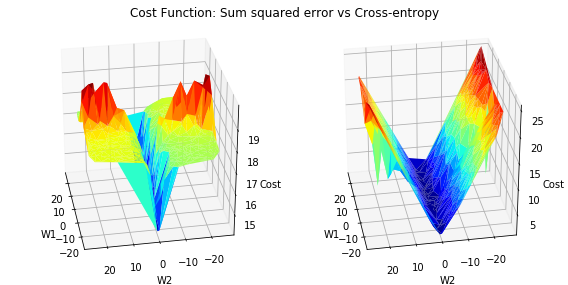

In [7]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

X, Y = joy.planar_data()   

W1 = np.random.permutation(np.linspace(-25, 25, 500))
W2 = np.random.permutation(np.linspace(-25, 25, 500))

fig = plt.figure(figsize=plt.figaspect(0.5))

zs0 = [sse_cost(X, Y, w1, w2) for w1, w2 in zip(W1, W2)]
zs1 = [cee_cost(X, Y, w1, w2) for w1, w2 in zip(W1, W2)]

ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax0.plot_trisurf(W1, W2, zs0, linewidth=0.01, cmap=cm.jet)
ax0.azim = 170
ax0.set_xlabel('W1')
ax0.set_ylabel('W2')
ax0.set_zlabel('Cost')

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot_trisurf(W1, W2, zs1, linewidth=0.01, cmap=cm.jet)
ax1.azim = 170
ax1.set_xlabel('W1')
ax1.set_ylabel('W2')
ax1.set_zlabel('Cost')
plt.suptitle('Cost Function: Sum squared error vs Cross-entropy')
fig.tight_layout()
plt.savefig('images/errorfunctions_3d', bbox_inches='tight', dpi=150)
plt.show()

우리가 NeuralNetwork를 개발할 때 사용한 오차함수는 SSE(Sum-squared error)제곱합 손실함수였습니다. 인위적으로 만든 꽃 자료와 삼층 신경망인 NeuralNetwork를 사용할 때 생길 수 있는 가중치 W1과 W2를 일정한 범위에서 변화할 때 나타날 수 있는 오차(비용, 손실)를 3차원 공간으로 나타내 보았습니다. 오른쪽에 있는 그림이 그것입니다. 
여기서 붉은 색일수록 오차가 큰 것을 의미하며, 짙은 파란색일수록 오차가 작은 곳은 깊은 계곡의 모양으로 보입니다.  경사 면도 상당히 거친 것을 관찰할 수 있습니다. 특히 중간에 있는 초원이나 노란색으로 나타난 부분은 '지역 최소'값이 나타나는 지역입니다. 이곳에서 도달하면 더 이상 '전역 최소'값으로 내려가기가 쉽지 않습니다. SSE를 사용할 경우, 이런 일이 종종 일어나는 것을 우리는 앞에서 관찰할 수 있었습니다. 

반면에, 우리가 이제 공부하고자 하는 크로스 엔트리 손실함수를 사용할 경우에는 SSE 손실함수에 비하여 훨씬 더 경사가 거칠지 않고, '지역 최소' 거의 없는 것으로 보입니다.  높은 곳에서 일단 하강을 시작하면 바로 계곡 밑바닥으로 갈 수 있을 것으로 보입니다.  잠시 후에, 우리가 직접 이런 일이 정말 일어나는지 확인이 할 수 있습니다. 

## 3. 로지스틱 회귀 3층 신경망 모델

이번 강의에서는 지금까지 사용해오던 SSE(Sum squared error)오차 함수가 아니라 새로운 로지스틱 손실함수 함수를 사용하는 3층 신경망을 시도합니다.  은닉층에는 4개의 뉴론이 있으며, 활성화 함수 tanh를 사용하고, 출력층에는 한 개의 뉴론이 있으며, 시그모이드 활성화 함수를 사용합니다. 또한 각 뉴론에 편향도 사용합니다. 

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/3LayerExampleModel.png?raw=true" width="650">
<center>그림 1: 로지스틱 3층 신경망 모델(편항 포함)</center>

위와 같은 신경망 모델에서 한 샘플 $x^{(i)}$에 대해 편향을 포함하여 다음과 같이 연산할 수 있습니다. 

1. 은닉층의 순입력 $z^{[1](i)}$은 가중치W1와 입력A0을 내적하고 편향을 합산한 값입니다. 
2. 은닉층의 출력 $a^{[1](i)}$은 은닉층의 순입력에 활성화 함수을 적용한 값입니다. 
3. 출력층의 순입력$z^{[2](i)}$은 가중치W2와 입력A1을 내적하고 편향을 합산한 값입니다. 
4. 출력층의 출력$a^{[2](i)}$은 즉 $\hat{y}^{(i)}$은 출력층의 순입력에 활성화 함수를 적용한 값입니다. 
5. 신경망의 $(i)$번째 예측값 $y^{(i)}_{predict}$
는 출력층의 출력$a^{[2](i)}$가 0.5보다 크면 1, 아니면 0이 됩니다.

이와 같은 한 샘플 $x^{(i)}$에 대한 위와 같은 연산을 행렬로 표시하면 다음과 같습니다. 
\begin{align} 
\\
z^{[1](i)} &= W^{[1]}x^{(i)} + b^{[1](i)} \tag{1-1} \\
a^{[1](i)} &= tanh(z^{[1](i)}) \tag{1-2}\\
z^{[2](i)} &= W^{[2]}a^{[1](i)} + b^{[2](i)} \tag{1-3}\\
y^{(i)} &= a^{[2](i)} = \sigma(z^{[2](i)}) \tag{1-4}\\
y^{(i)}_{predict} &= 
\begin{cases} 
    1 & \mbox{if } a^{[2](i)} > 0.5 \\ 
    0 & \mbox{otherwise } 
\end{cases}  \tag{1-5} \\
\end{align}

참고로, 위의 그림에서 알수 있듯이, $b^{[1]}$의 형상은 (4, 1)이 될 것이며, $b^{[2]}$ 형상은 (1, 1)이 될 것입니다.

## 4. 로지스틱 함수$^{logistic \ function}$ 

로지스틱 신경망 모델을 이해하기 위해서, 우리는 먼저 로지스틱 함수가 무엇인지 알아보도록 하겠습니다. 

로지스틱 회귀 함수는 결과 값을 확률로 계산하길 원할 때 사용합니다.  예를 들면, 집의 면적과 위치와 주변 시세에 따라 집값을 예측하는 것은 선형 회귀 모델을 사용할 수 있습니다.  그러나, 만약에 어느 지역에 비가 올 것인지 아닌지 같은 결과는 확률로 계산하는 것이 더 유익할 것입니다.  확률이란 그 값의 범위가 0부터 1사이입니다.  0는 전혀 일어나지 않는 경우이며, 1은 항상 일어나는 경우입니다.  각 입력 자료에 대해 그 자료가 클래스 1 혹은 0 속할 가능성에 대한 확률을 구하는 문제입니다.  일반적인 연속적인 값을 구하는 것이 아닌 것이죠.  이런 경우의 문제는 선형 회귀분석이 아니라 로지스틱 회귀문제로 접근합니다.  선형 회귀분석은 입력 값 x에 대한 y의 값 즉 연속적인 값 중에 한 값을 예측하는 모델입니다.  어떤 지역의 많은 집값으로 학습을 한 후, 그 지역의 특정한 집값을 예측하는 모델같은 경우입니다.  

로지스틱 회귀는 입력 값 x에 대하여 y의 값이 연속적인 숫자의 하나로 나타내는 것이 아니라 어떤 특정 분류에 속하는지 속하지 않는지에 대한 결과를 얻기 위한 모델입니다.  예를 들면, 카드 사용 패턴이 정상적인지 아닌지 판단하는 경우입니다. 카드 사용 패턴이 정상적일 확률을 구하여, 0.5보다 크면 정상이라고 판단하고, 그 이하이면 비정상으로 판단하는 것입니다. 

주어진 자료로 기계학습 과정을 거칠 때 판별된 결과 값은 0와 1사이의 값으로 출력이 되어야 합니다.   그러므로, 기존의 선형 회귀식(1)으로 사용한 $Z = W \cdot X$와 같은 1차 함수들은 그 결과 값의 범위가 음의 무한대에서 양의 무한대이므로 연속적으로 변화하는 입력 값에 대하여 0 또는 1로 결과를 표현하기 어렵습니다.  왜냐하면, 편향$^{bias}$값으로만도 1보다 더 큰 값을 가질 수 있기 때문입니다. 

\begin{align}   Z =  W \cdot X  \tag{2} \end{align}

-----------

__JoyQuiz__: 메일이 스팸인지 아닌지, 카드가 잘못 사용된 것인지 아닌지 판별하는 것은 어느 모델을 사용하는 것이 더 나은가요?

(1) 로지스틱 회귀 모델 <br>
(2) 선형 회귀 모델

__JoyAnswer__: (1)

-------------

우리는 기존의 선형 회귀식이 아닌 다른 식이 필요한 것입니다. 우리가 결과 값으로 구하려고 하는 확률은 0와 1사이 입니다.  그래서, 확률 p를 0와 1사이가 아니라 이것을 음의 무한대에서 양의 무한대까지 나오도록 하는 $p$에 대한 함수를 만들고자 합니다.  이를 위해 필요한 것은 승산비$^{odds \ ratio}$과 $log$입니다. 

승산비는 실패 확률에 대한 성공 확률의 비율입니다.  성공 확률을 $p$라고 한다면 실패 확률은 $1-p$가 될 것입니다.  그러므로 그 승산비는 다음과 같습니다. 

\begin{align}   odds \ ratio = \frac{Sucess}{Fail} = \frac{p}{1-p} \qquad
  \begin{cases}
   0\quad \text{if $p \to 0$}.\\
   +\infty  \quad \text{if $p \to 1$}. \\
  \end{cases}
\tag{3-1} \end{align}

식(3-1)의 결과로 나타낼 수 있는 수의 범위는, 수학의 극한 개념을 적용하면, 0부터 양의 무한대입니다.  그러나, 식(3-1)가 나타낼 수 있는 수의 범위는 아직도 0부터 음의 무한대를 포함하지 않고 있습니다.  이를 포함하기 위해서 식(3-1) 자연로그를 취합니다.  이 함수를 __로짓$^{logit}$ 함수__라고 부릅니다. 

\begin{align}   z = logit(odds \ ratio) = \log_e \frac{p}{1-p} \qquad
  \begin{cases} 
     -\infty \quad \text{if $p \to 0$}.  \\
     +\infty \quad \text{if $p \to 1$}. \\  
  \end{cases} \tag{3-2} 
\end{align}

로짓 함수 식(3-2)의 결과로 나타낼 수 있는 수의 범위는 과연 음의 무한대부터 양의 무한대일까요?  식(3-1)에서와 같이 $p$가 $0$로 수렴하면, $p/(1-p)$는 0로 수렴하고, 그 때 식(3-2)은 $log_e(\sim~0)$가 됩니다.  그러므로, $e^{-\infty} = 0$가 되어야 하므로, 로지트 함수의 영역은 음의 무한대도 포함합니다. 

식(3-1)와 식(3-2)을 p에 대하여 그래프를 그려보면 다음과 같습니다. 

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/oddsRatioLogisticPlot.png?raw=true" width="650">
<center>그림 2: 로지스틱 함수의 범위</center>

위 그림을 그리는 코드를 보려면 다음 셀의 첫 줄의 #를 삭제하고, 셀을 실행하여 파일을 불러드린 후, 셀을 다시 실행하십시오. 

In [137]:
#load code/oddsRatioLogisticPlot.py

그러면, 이제 식(1)을 다음과 같이 바꾸어 쓸 수 있습니다. 
\begin{align}   \log_e \frac{p}{1-p} &=  W \cdot X  \\ \tag{4} \end{align}

자, 이제 남은 것은 식(4)를 p에 대한 식으로 풀어주기만 하면 됩니다. 왜냐하면, 우리의 목적은 이 함수를 통해 확률 p를 찾는 것이었습니다.  식(4)는 다음과 같이 다시 쓸 수 있습니다. 

\begin{align}   \frac{p}{1-p} =  e^{W \cdot X}  \tag{5} \end{align}

식(5)는 다시 odds ratio와 같은 함수가 되었습니다. __양 변에 역수__를 취하고 정리하면 다음과 같습니다. 
\begin{align}   
    odds \ ratio = \frac{1-p}{p} &= \frac{1}{e^{W \cdot X}} \\
    \frac{1}{p} - 1 &= \frac{1}{e^{W \cdot X}} \\
    \frac{1}{p} &= \frac{1}{e^{W \cdot X}} + 1\\
                   &= \frac{1}{e^{W \cdot X}} + \frac{e^{W \cdot X}}{e^{W \cdot X}}   \\
                   &= \frac{1 + e^{W \cdot X}}{e^{W \cdot X}}   \\
              p &= \frac{e^{W \cdot X}} {1 + e^{W \cdot X}}  \\
\tag{6} \end{align}

여기서 우리에게 익숙한 로지스틱 함수와 같게 만들기 위해, 분자의 값으로 분모와 분자를 모두 나누고 정리하면 드디어 로지스틱 함수가 만들어집니다. 이 로지스틱 함수가 우리가 찾고자하는 가설함수 $h_w(x)$ 혹은 간단히 $h(z)$가 됩니다. 축하합니다. 

\begin{align}   
    p &= \frac{e^{W \cdot X}} {1 + e^{W \cdot X}}  \\
       &= \frac{1} {\frac{1}{e^{W \cdot X}} + 1}  \\
       &= \frac{1} {1 + e^{- W \cdot X}}  \\ 
    h(z) &= \frac{1} {1 + e^{- W \cdot X}} = \frac{1} {1 + e^{- Z}}\tag{7}  
\end{align}

이 함수를 __로지스틱$^{logistic}$ 함수__ 혹은 __로지스틱 시그모이드$^{sigmoid}$ 함수__라고 하며, 로지스틱 함수는 로지트 함수의 역함수입니다. 즉 로지스틱 함수는 $-\infty$부터 $+\infty$까지의 값을 가지는 입력값을 0부터 1사이의 값으로 반환합니다.  

[시그모이드 함수](https://en.wikipedia.org/wiki/Sigmoid_function)는 항상 0 또는 양의 기울기를 가지는 함수 즉 S자 모양을 나타내는 함수에 대한 일반적인 이름이며, 이에는 로지스틱 함수, 하이퍼볼릭 탄젠트 함수, 오차 함수등이 있습니다. 



__JoyQuiz__: h(z) 함수의 출력 범위는 얼마입니까? 

(1) $0 <= h(z) <= \infty$  <br>
(2) $-\infty <= h(z) <= \infty$ <br>
(3) $-1 <= h(z) <= 1$ <br>
(4) $ 0 <= h(z) <= 1$

__JoyAnswer__: (4)


\begin{align}
  \sigma(x) = \frac{1}{1 + e^{-x}} \
  \begin{cases}
   \sigma(x) \rightarrow 1 \ \quad if \ x \rightarrow  +\infty  \\
   \sigma(x) \rightarrow \frac{1}{2} \quad if \ x \rightarrow 0 \\
   \sigma(x) \rightarrow 0 \ \quad if \ x \rightarrow -\infty \\
  \end{cases} 
\end{align}

# --- 여기서 강의 끊기 ---

### 로지스틱 회귀 모델 이해하기 

입력 자료가 2차원인 경우를 시각화하면 식(7)으로 나타나는 로지스틱 회귀 모델을 이해하는데 도움이 될 것입니다. $WX$의 값의 범위는 $-\infty$와 $+\infty$입니다. 반면에 출력값 $y$의 범위는 0와 1입니다. 결정 경계는 $WX=0$인 결정경계$^{decision \ boundary}$를 나타내는 하이퍼플레인$^{hyperplane}$입니다. 입력 자료가 2차원인 경우를 아래와 같이 시각화할 수 있습니다. 

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/logisticClassifier1.png?raw=true" width="600">
<center>그림 3: 2차원 로지스틱 회귀 분류(1)</center>

로지스틱 회귀 모델은 위의 그림과 같은 입력자료(빨간 점과 까만 점)로 로지스틱 회귀 학습을 진행하여 입력자료를 두 클래스$(y \in \{1, 0\})$로 분류하는 가중치 $W$를 구하는 것입니다.  

예를 들어, 로지스틱 회귀 모델로 우리가 가중치 $W = [-3, 1, 1]$ 을 구했다고 가정합시다.  그러면, $y = 1, y = 0$인 영역과 결정경계$^{decision \ boundary}$은 어떻게 되겠습니까? 

그러면, $ h(z) = g(WX) = g(w_0 + w_1x_1 + w_2x_2) = -3 + x_1 + x_2 $

여기서 $WX >= 0$ 즉 만약 $ -3 + x_1 + x_2 >=0 $ 을 만족하면 $y = 1$이라고 예측한다는 것입니다. 이 조건식을 만족하는 모든 자료 $x_1, \ x_2$이 클래스 y = 1에 해당합니다. 이것을 수식과 그림에 나타내면 다음과 같습니다. 
\begin{align}
-3 + x_1 + x_2 &>= 0 \\
       x_1 + x_2 &>= 3  \qquad \text{then} \ y = 1.\\
\end{align}
<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/logisticClassifier2.png?raw=true" width="500">
<center>그림 4: 2차원 로지스틱 회귀 분류(2)</center>

__JoyQuiz__: 위의 그림에서 결정경계는 $x_1 + x_2 = 0$ 으로 나타납니다. 이 결정경계에서의 $h(z)$값은 무엇입니까? 

__JoyAnswer__: $h(z) = 0.5$

한 가지 유의할 것은 로지스틱 함수의 입력 $z$ 즉 $WX$는 전혀 선형일 필요가 없습니다.  어떠한 고차원 다항식일 수 있습니다.  예를 들면, $z = w_0 + w_1x_1^{2} + w_2x_2^{2}$식은 원형으로 결정경계를 나타낼 수 있기에 아래와 같은 자료도 문제없이 분류할 수 있으며, 이보다도 훨씬 더 복잡한 형태의 함수도 결정경계로 표현할 수 있습니다. 

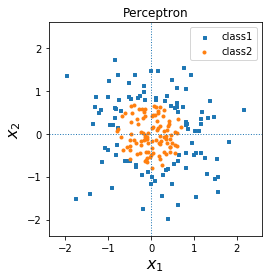

In [8]:
x, y = joy.gaussian_quantiles()
joy.plot_xyw(x.T, y.squeeze())

--------------

__JoyQuiz__: 입력자료 x로부터 비가 올 것인지$(y = 1)$, 오지 않을 것인지$(y = 0)$를 예측하길 원한다고 가정합시다.  로지스틱 회귀 분류를 통해 $h_w(x) = p(y = 1 \ | \ x; w) = 0.7$라는 결과가 나왔다면, $p(y = 0) \ | \ x; w)$ 즉 비가 오지 않을 확률$(y = 0)$은 얼마입니까? 

(1) $h_w(x) = p(y = 1 \ | \ x; w) = 0.7$ <br>
(2) $h_w(x) = p(y = 1 \ | \ x; w) = 0.3$ <br>
(3) $h_w(x) = p(y = 1 \ | \ x; w) = 0.7^2 $ <br>
(4) $h_w(x) = p(y = 1 \ | \ x; w) = 0.3^2 $ 

__JoyAnswer__: (2)

-------------------

## 5. 로지스틱 회귀$^{logistic \ regression}$의 비용함수

선형 회귀에서 오차함수 $E$는 다음과 같이 정의했습니다. 

\begin{align}   E = \frac{1}{m}\sum_{i=1}^{m}\frac{1}{2}\left(y^{(i)} - \hat{y}^{(i)} \right)^2 \end{align}

선형 회귀에서는 y = WX를 사용했지만, 로지스틱 회귀에서는 $ y = h(z) = \frac{1}{1 + e^{-wx}}$ 함수를 사용하기 때문에 이를 선형회귀와 같이 오차함수를 제곱의 합(SSE, Sum of Squared Error)로 정의할 수 없습니다.  왜냐하면, 선형 회귀처럼 제곱의 합으로 오차함수를 정의하면, 전역 최소값으로 자연스럽게 수렴할 수 있는 콘벡스(convex) 함수가 나타나지 아니하기 때문입니다. 

오차 제곱의 합을 사용하는 오차함수 E와 단순히 구별하기 위하여, 로지스틱 회귀에서는 비용함수 J라고 부르기로 하겠습니다. 

로지스틱 회귀를 사용하는 신경망에서는 비용함수를 다음과 같이 정의합니다.  여기에서 $log$는 밑이 $e$인 자연로그($log_e$)이며, h(z)는 신경망의 출력값이며, y는 클래스 레이블입니다.  

\begin{align}   J = \begin{cases}
   -\log\left(h(z)\right)  \qquad \text{if y = 1}. \tag{8-1} \\
   -\log\left(1- h(z)\right) \ \ \text{if y = 0}. \\
  \end{cases} 
\end{align}

이해를 돕기 위해, 식(8-1)을 하나의 노드 출력의 관점에서 기술하면 다음과 같습니다. 

\begin{align}   e^{(i)} = \begin{cases}
   -\log\left(a^{[2](i)}\right)  \qquad \text{if y = 1}. \tag{8-2} \\
   -\log\left(1- a^{[2](i)}\right) \ \ \text{if y = 0}. \\
  \end{cases} 
\end{align}

\begin{align}   e^{(i)} = \begin{cases}
   -\log\left(\hat{y}\right)  \qquad \text{if y = 1}. \tag{8-3} \\
   -\log\left(1- \hat{y}\right) \ \ \text{if y = 0}. \\
  \end{cases} 
\end{align}

식(8)에서 보듯이 클래스 레이블 y값에 따라, 즉 결과값으로 어떤 값을 기대하느냐에 따라 서로 다른 함수를 적용해야 합니다. 클래스 레이블 $y = 1$인 경우의 예를 들면, 신경망 노드의 출력($\hat{y}= a^{[2](i)}$)이 1이 나와야 하는데, 1에 가까운 값이 나오면 그 때 비용은 작은 값이 되어야 하고, 출력이 0가 나온다면, 그 때 비용은 큰 값이 되어야 합니다. 그래서, 이를 반영하여 비용(오차)을 줄이기 위한 작업(역전파)을 시작할 수 있습니다. 

식(8)의 두 개의 서로 다른 경우의 함수를 그래프로 그리면 다음과 같이 서로 대칭적인 모양을 가지고 있습니다. 

<img src='https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/logisticCostFunction.png?raw=true' width="500">
<center>그림 5: 로지스틱 회귀의 비용함수</center>

위 그림을 그리는 코드를 보려면 다음 셀의 첫 줄의 #를 삭제하고, 셀을 실행하여 파일을 불러드린 후, 셀을 다시 실행하십시오. 

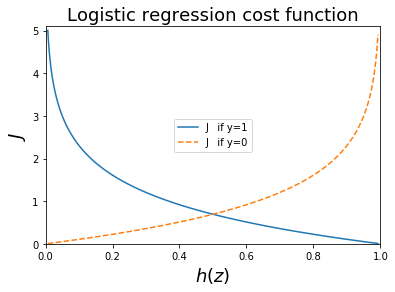

In [9]:
# %load code/logisticCostFunctionPlot.py
#2018/05/01 coded joyfully by idebtor@gmail.com
import numpy as np
import matplotlib.pyplot as plt
import joy
z = np.arange(-5, 5, 0.1)
hz = joy.sigmoid(z)

c1 = [(lambda z: -np.log(joy.sigmoid(z)))(x) for x in z]
plt.plot(hz, c1, label='J   if y=1')
c0 = [(lambda z: -np.log(1-joy.sigmoid(z)))(x) for x in z]
plt.plot(hz, c0, label='J   if y=0', linestyle='--')
plt.xlim([0,1])
plt.ylim(0.0, 5.1)
plt.xlabel('$h(z)$', fontsize=18)
plt.ylabel('$J$', fontsize=18)
plt.title('Logistic regression cost function',  fontsize=18)
plt.legend(loc='center')
plt.savefig('images/logisticCostFunction.png', dpi = 150)
plt.show()

__JoyQuiz__: 식(8) 혹은 로지스틱 비용함수 그래프를 보지 않고, 다음을 답하십시오. 
만약, y = 1, h(z) = 1이면, 비용함수에서 비용이 0 되어야 합니까 아니면 극대화되어야 합니까? 
(1) 0가 되어야 합니다. 
(2) 극대화되어야 합니다. 

__JoyAnswer__: 비용은 0가 되어야 합니다. 클래스 레이블과 예측값이 같으니, 제대로 학습을 한 것이므로, 비용함수가 0 되어야 역전파에서 오차를 전파하지 않고, 따라서 가능한 가중치의 값을 유지하게 됩니다. 

식(8)의 두 경우를 결합하여 하나의 수식으로 표현하면 다음과 같습니다. 

\begin{align}   e^{(i)} = -y\log\left(a^{[2] (i)}\right) -(1-y)\log\left(1- a^{[2] (i)}\right) \tag{9} 
\end{align}

두 식을 하나의 수식으로 조건도 없이 표현할 수 있다는 것이 놀랍죠?  정말 그런지 체크를 해볼까요?  

식(9)에 $y = 1$를 대입해보면, 둘째 항이 $0$이 되므로 식(8)의 첫째 식과 동일하게 되고, 식(9)에 $y = 0$를 대입하면 첫째 항이 $0$이 되므로, 이는 식(8)의 둘째 식과 동일하게 되는 것을 알 수 있습니다. 

이를 모든 자료에 적용하여 오차를 합산하면 비용함수가 되는데, 이를 __로지스틱 회귀 비용함수__라고 합니다.  

\begin{align}   
  J(w) &= - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{10} 
\end{align}

식(9), (10)은 사실상 크로스$^{교차}$ 엔트로피$^{cross \ entropy}$ 비용함수와 같은 형태입니다. 식(9)에서 $y$를 $y^{(1)}, a^{[2] (i)}$을 $\hat{y}^{(1)}$으로, $y-1$을 $y^{(2)}, 1- a^{[2] (i)}$을 $\hat{y}^{(2)}$ 치환하면, 식(9)는 다음과 같습니다. 

\begin{align}   e^{(i)} &= -y\log\left(a^{[2] (i)}\right) -(1-y)\log\left(1- a^{[2] (i)}\right)  \\ \tag{11} 
                             &= -y^{(1)} log (\hat{y}^{(1)}) - y^{(2)} log(\hat{y}^{(2)})  \\
                             &= -\sum_{i=1}^2 y^{(i)}  log(\hat{y}^{(i)})
\end{align}

이를 한 샘플에 대해 일반화하면 크로스 엔트로피 비용함수는 다음과 같습니다. 

\begin{align}   J &= -\sum_{i} y^{(i)}  log(\hat{y}^{(i)})
\end{align}


여기서 $y^{(i)}$는 신경망의 클래스 레이블이며, $\hat{y}^{(i)}$은 출력입니다. 원-핫-인코딩(나중에 다루게 됨)에 사용되어 $y^{(i)}=1$ 일때, 신경망 출력 $\hat{y}^{(i)}$의 자연로그를 계산하는 식이 됩니다. 정답(레이블)이 아닌 나머지는 모두 0가 되어 로그를 곱해도 결과에 영향을 주지 않습니다.  예를 들면, 레이블 5이라고 할 때, 신경망의 출력이 0.6이라면, 크로스 엔트로피 오차는 -log 0.6 = 0.51이 됩니다.  같은 조건에 출력이 0.1이라면, -log 0.1 = 2.30이 됩니다. 

이를 또한 전체 학습 자료 m개에 대해 일반화하면 평균 크로스 엔트로피 오차(ACE: Averaged Cross Entropy Error)는 다음과 같습니다. 

\begin{align}   J(w) &= -\frac{1}{m}\sum_{m}\sum_{i} y^{(i)}  log(\hat{y}^{(i)})
\end{align}

크로스 엔트로피에 관한 이론적 및 수학적 배경은 [여기](http://colah.github.io/posts/2015-09-Visual-Information/)를 참조하십시오. 

### 크로스 엔트로피 계산 예제 1

신경망ABC라고 불리는 신경망에 입력 A, B, C에 대해 다음과 같이 클래스 레이블과 예측값(출력)이 주어졌습니다. 

샘플|$y$:레이블 ||  $\hat{y}$:예측값(A,B,C)  ||  분류결과? 
---|:--------:||:--------------:||--------------
1  |0    0   1||  0.3  0.3  0.4 || C, True 
2  |0    1   0||  0.3  0.4  0.3 || B, True 
3  |1    0   0||  0.1  0.2  0.7 || C, False 

평균 크로스 엔트로피(ACE:Averaged Cross Entropy Error)를 구하십시오.

 

크로스 엔트로피에 의한 오차는 다음과 같이 정의합니다. 

\begin{align} J = -\sum_{i} y^{(i)}  log(\hat{y}^{(i)}) \end{align}

첫번째 샘플의 경우, 

$ J = - ( 0 * ln(0.3) + 0 * ln(0.3) + 1 * ln(0.4) ) = - ln(0.4)$

두번째 샘플의 경우, 

$ J = - ( 0 * ln(0.3) + 1 * ln(0.4) + 0 * ln(0.3) ) = - ln(0.4)$

세번째 샘플의 경우,

$ J = - ( 1 * ln(0.1) + 0 * ln(0.2) + 1 * ln(0.7) ) = - ln(0.1)$

그러므로, 평균 크로스 엔트로피를 구하면,   

$ J = - (ln(0.4) + ln(0.4) + ln(0.1) = -(-0.916 -0.916 - 2.3) = 1.38 $


### 크로스 엔트로피 계산 예제 2

신경망DEF라고 불리는 신경망에 입력 D, E, F에 대해 다음과 같이 클래스 레이블과 예측값(출력)이 주어졌습니다.



샘플|$y$:레이블 ||  $\hat{y}$:예측값(D,E,F)  ||  분류결과? 
---|:--------:||:--------------:||:--------------|
1  |0    0   1||  0.1  0.2  0.7 || F, True 
2  |0    1   0||  0.1  0.7  0.2 || E, True 
3  |1    0   0||  0.3  0.4  0.3 || E, False  

평균 크로스 엔트로피(ACE)를 구하십시오.
크로스 엔트로피에 의한 오차는 다음과 같이 정의합니다. 

\begin{align} J = -\sum_{i} y^{(i)}  log(\hat{y}^{(i)}) \end{align}

첫번째 샘플의 경우, 

$ J = - ( 0 * ln(0.1) + 0 * ln(0.2) + 1 * ln(0.7) ) = - ln(0.7)$

두번째 샘플의 경우, 

$ J = - ( 0 * ln(0.1) + 1 * ln(0.7) + 0 * ln(0.2) ) = - ln(0.7)$

세번째 샘플의 경우,

$ J = - ( 1 * ln(0.3) + 0 * ln(0.4) + 0 * ln(0.3) ) = - ln(0.3)$

평균 크로스 엔트로피(ACE: Averaged Cross Entropy Error)를 구하면,   

$ J = - (ln(0.7) + ln(0.7) + ln(0.3) = -(-0.357 -0.357 - 1.204) = 0.64 $

신경망ABC와 신경망DEF의 오차를 비교해 보면 신경망DEF의 오차가 더 작습니다.  즉, 신경망이 출력한 분류 오차에 정확도가 고려되어 최적화 관점에서 어떤 신경망이 더 잘 학습되었는지를 알 수 있다. 두 개의 log함수가 결합된 크로스 엔트로피 손실함수가 그렇게 계산되게 만드는 것입니다.  

### 예제 1 & 2 신경망의 평균 제곱 오차(MSE) 계산

예제1 신경망의 경우, 

샘플1(T): (0 - 0.3)^2 + (0 - 0.3)^2 + (1 - 0.4)^2 = (0.09 + 0.09 + 0.36) = 0.54

샘플2(T): (0 - 0.3)^2 + (1 - 0.4)^2 + (0 - 0.3)^2 = (0.09 + 0.36 + 0.09) = 0.54

샘플3(F): (1 - 0.1)^2 + (0 - 0.2)^2 + (0 - 0.7)^2 = (0.81 + 0.04 + 0.49) = 1.34

평균 제곱 오차(MSE) = (0.54 + 0.54 + 1.34) / 3 = 0.81

예제2 신경망의 경우, 
샘플1(T): (0 - 0.1)^2 + (0 - 0.2)^2 + (1 - 0.7)^2 = (0.01 + 0.04 + 0.09) = 0.14

샘플2(T): (0 - 0.1)^2 + (1 - 0.7)^2 + (0 - 0.2)^2 = (0.01 + 0.09 + 0.04) = 0.14

샘플3(F): (1 - 0.3)^2 + (0 - 0.4)^2 + (0 - 0.3)^2 = (0.49 + 0.16 + 0.09) = 0.74

평균 제곱 오차(MSE) = (0.14 + 0.14 + 0.74) / 3 = 0.34

### 크로스 엔트피와 평균 제곱 오차의 비교

예제1 신경망에서 각 샘플의 오차를 살펴보면, 샘플3의 오차가 가장 크게 나타나고, 예제2 신경망에서도 역시 샘플3 오차가 가장 크게 나타납니다. 신경망의 계산 결과에서 보듯이 MSE는 틀린 샘플에 대해 더 집중하는 특성을 나타내고 있습니다. 맞은 것과 틀린 것에 대해 오차를 똑같이 다루어 주여야 하는데 그렇지 않아 오차 정의로는 적절하지 않습니다.

예를 들어, 1 혹은 0로 분류하는 문제라고 한다면, MSE를 사용할 경우 가중치를 조정할 때 기울기 값과 yhat * (1 - yhat)을 곱하는 요소가 포함하고 있습니다. 그런데, 출력 yhat가 0.6이라고 한다면, yhat(1-yhat) = 0.24를 곱하여 학습을 진행할 수 있습니다. 그런데, 만약 출력 yhat이 0.95라면, yhat(1-yhat) = 0.0475입니다. 조정할 값이 점점 작아지게 되므로 가중치 변화도 점점 작아지고 학습 진행이 아주 느려질 수 있습니다. 

그러나 ACE를 사용하면  yhat(1-yhat)항이 사라지므로, 1, 0에 따라 가중치 변화가 작아지는 현상이 없으며, 학습이 아주 느려질 수 없게 됩니다. 

또한 출력층에 소프트맥스 활성화 함수를 사용하면, 출력을 상대적으로 boosting해줌으로 역전파에서 효과적으로 가중치를 증감시킬 수 있습니다. 

Reference: [James D. Mcaffrey](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/)

# 크로스 엔트로피 예제

어느 신경망에서 입력이 강아지인데, 출력층의 3개의 뉴론은 각각 강아지, 고양이, 송아지일 확률을 0.1, 0.8, 0.3으로 출력했다고 하면, 이 모델은 제대로 분류를 하지 못한 것입니다. 이 때 레이블과 출력을 각각 다음과 같이 표기할 수 있습니다. 

\begin{align} y = \begin{pmatrix} dog \\ cat \\ cow \end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}, \quad 
\hat{y} = \begin{pmatrix} 0.1 \\ 0.8 \\ 0.3 \end{pmatrix} \end{align}

학습자료 m개에 대해 일반화한 평균 크로스 엔트로피 오차(ACE: Averaged Cross Entropy Error)는 다음과 같습니다. 

\begin{align}   J(w) &= -\frac{1}{m}\sum_{m}\sum_{i} y^{(i)}  log(\hat{y}^{(i)})
\end{align}

#### 크로스 엔트로피 오차를 계산하십시오. 

$J = -(1 * ln(0.1) + 0 * ln(0.8) + 0 * ln(0.3)) = - ln(0.1) = 2.3 $


\begin{align} \begin{pmatrix} 
0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 
\end{pmatrix} \end{align}

\begin{align} \begin{pmatrix} 
0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0 
\end{pmatrix} \end{align}

\begin{align} \begin{pmatrix} 
0 & 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 
\end{pmatrix} \end{align}

### 로지스틱 회귀 비용함수의 미분 

비용함수 식(10)을 미분하여 이 함수값을 최소하는 가중치 W를 찾아가는 과정은 곧 기계학습입니다.  미분을 진행하기 전에 미리 알아두면 편리한 미분 공식이나 표기들이 있습니다. 

------
\begin{align}
  \frac{du^n}{dx} & = n u^{n-1}\frac{du}{dx} \\
  \frac{d}{d x} log(x) &= \frac{1}{x} \\
  \frac{d}{d x} f(g(x)) &= f'(g(x))g'(x) \\
  \sigma(z) &= \frac{1}{1 + e^{-z}} \\
  \frac{\partial}{\partial w_j}\sigma(z) &= \sigma(z)(1 - \sigma(z))\frac{\partial}{\partial w_j}z 
\end{align}

- 다음 식에서 $h_w(x^{(i)})$은 뉴론의 입력값에 활성화 함수를 적용한 출력값 즉 $a^{[2] (i)}$를 의미합니다.   
- 단순히 수식을 읽기 쉽게 하기 위하여 $h_w(x^{(i)}) = h(z), \ z = wx^{(i)}$으로 치환하여 표기합니다. 
- 시그모이드 함수를 사용하므로, $h(z) = \sigma(z)$ 입니다.

------

\begin{align} 
a &= h(z) = \sigma(z) \\
z &= wx \\
  \frac{d}{d x} log(x) &= \frac{1}{x} \\
  \sigma(z) &= \frac{1}{1 + e^{-z}} \\
  \frac{\partial}{\partial w_j}\sigma(z) &= \sigma(z)(1 - \sigma(z))\frac{\partial}{\partial w_j}z 
\end{align}

\begin{align}  
  J(w) &= - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) 
\end{align}

\begin{align} 
  \frac{\partial J(w)}{\partial w_j}  &= \frac{\partial}{\partial w_j} \,\frac{-1}{m}\sum_{i=1}^m 
  \left[y \log(a) + (1 - y) \log(1-a) \right]  
  \qquad \qquad \because a = h(z) = \sigma(z)\\
  &= \frac{\partial}{\partial w_j} \,\frac{-1}{m}\sum_{i=1}^m 
  \left[y \log(\sigma(z)) + (1 - y) \log(1- \sigma(z)) \right]  
  \qquad \because  \frac{d}{d x} log(x) = \frac{1}{x} \\
    &= \frac{-1}{m}\sum_{i=1}^m 
  \left[\frac{y}{\sigma(z)} \frac{\partial \sigma(z)}{\partial w_j} + \frac{(1 - y)}{1- \sigma(z)}\frac{\partial (1-\sigma(z))}{\partial w_j} \right] 
  \qquad \because   \frac{d}{d x} f(g(x)) = f'(g(x))g'(x) \\ 
    &= \frac{-1}{m}\sum_{i=1}^m 
  \left[\frac{y}{\sigma(z)}  - \frac{(1 - y)}{1- \sigma(z)} \right]\frac{\partial \sigma(z)}{\partial w_j}  \\
\frac{\partial J(w)}{\partial w_j} 
    &= \frac{-1}{m}\sum_{i=1}^m 
  \left[\frac{y}{\sigma(z)}  - \frac{(1 - y)}{1- \sigma(z)} \right] \sigma'(z)x_j  \qquad \qquad \because z = w_jx_j\\
        &= \frac{-1}{m}\sum_{i=1}^m 
  \left[\frac{y(1- \sigma(z)) - \sigma(z)(1 - y)}{\sigma(z)(1- \sigma(z))} \right] \sigma'(z)x_j  \\
          &= \frac{-1}{m}\sum_{i=1}^m 
  \left[y(1- \sigma(z)) - \sigma(z)(1 - y) \right] x_j  \qquad \qquad \because \sigma'(z) = \sigma(z)(1 - \sigma(z))\\
            &= \frac{-1}{m}\sum_{i=1}^m 
  \left[y - \sigma(z) \right] x_j  \\
  &= - \frac{1}{m}\sum_{i=1}^m\left[y^{(i)} - \hat{y}^{(i)}\right]\, x_j^{(i)} 
\end{align}                                                                     

자, 그러면 비용함수 (10)의 미분을 진행해봅시다. 

\begin{align} 
  \frac{\partial J(w)}{\partial w_j}  &= \frac{\partial}{\partial w_j} \,\frac{-1}{m}\sum_{i=1}^m 
  \left[ y^{(i)}\left(\log (h_w(x^{(i)}) \right) + (1 -y^{(i)})\left(\log(1-h_w(x^{(i)})\right)\right]  \\ 
  &\underset{h_w(x^{(i)})=h(z)}= \frac{-1}{m}\sum_{i=1}^m 
  \left[ y^{(i)}\frac{\partial}{\partial w_j} \log (h(z)) + (1 -y^{(i)})\frac{\partial} {\partial w_j}  \left(\log(1-h(z))\right)\right]  \\ 
  &\underset{\text{chain rule}}= \,\frac{-1}{m}\,\sum_{i=1}^m 
\left[ y^{(i)}\frac{\frac{\partial}{\partial w_j}h(z)}{h(z)} +
(1 -y^{(i)})\frac{\frac{\partial}{\partial w_j}\left(1-h(z)\right)}{1-h(z)}\right]\\[2ex]
&\underset{h(z)=\sigma(z)}=\,\frac{-1}{m}\,\sum_{i=1}^m 
\left[ y^{(i)}\frac{\frac{\partial}{\partial w_j}\sigma(z)}{h(z)} 
+ (1 -y^{(i)})\frac{\frac{\partial}{\partial w_j}\left(1-\sigma(z)\right)}{1-h(z)} \right]\\[2ex]
&\underset{\sigma'}=\frac{-1}{m}\,\sum_{i=1}^m 
\left[ y^{(i)}\, \frac{\sigma(z)\left(1-\sigma(z)\right)\frac{\partial}{\partial w_j}(z)}{h(z)} 
- (1 -y^{(i)})\,\frac{\sigma(z)\left(1-\sigma(z)\right)\frac{\partial}{\partial w_j}(z)}{1-h(z)} \right]\\[2ex]
&\underset{\sigma(z)=h(z)}= \,\frac{-1}{m}\,\sum_{i=1}^m 
\left[ y^{(i)}\frac{h(z)\left(1-h(z)\right)\frac{\partial}{\partial w_j}(z)}{h(z)} 
-(1 -y^{(i)})\frac{h(z)\left(1-h(z)\right)\frac{\partial}{\partial w_j}(z)}{1-h(z)} \right] \\[2ex] 
&\underset{\frac{\partial}{\partial w_j}(z)=x_j^{(i)}}=\,\frac{-1}{m}\,\sum_{i=1}^m \left[y^{(i)}\left(1-h(z)\right)x_j^{(i)}-
\left(1-y^{(i)}\right)\,h(z)x_j^{(i)} \right]\\[2ex]
&\underset{\text{factoring}}=\,\frac{-1}{m}\,\sum_{i=1}^m 
\left[y^{i}-y^{i}h(z)-h(z)+y^{(i)}h(z) \right]\,x_j^{(i)}\\[2ex]
&\underset{h(z)=h_w(x^{(i)})}=\,\frac{-1}{m}\,\sum_{i=1}^m \left[y^{(i)}-h_w(x^{(i)})\right]\,x_j^{(i)}\\[2ex]
&= - \frac{1}{m}\sum_{i=1}^m\left[y^{(i)} - h_w(x^{(i)})\right]\, x_j^{(i)} \\ 
&= - \frac{1}{m}\sum_{i=1}^m\left[y^{(i)} - \hat{y}^{(i)}\right]\, x_j^{(i)} 
\tag{12}
\end{align}



비용함수 미분의 최종 결과로 다음과 같은 식을 유추할 수 있습니다. 
그러므로, 

\begin{align}
\Delta W^{[2]} &= \frac{\partial J}{\partial W^{[2]}} 
               = - \frac{1}{m} E^{[2]} (1) A^{[1]T}  \tag{13}
\end{align}

미분 결과인 식(12)와 식(13)을 우리가 예전에 시도했던 제곱 합(SSE) 오차함수의 미분과 비교해보기로 합시다. 

출력층 노드 k의 오차함수(SSE)를 하나의 가중치 $w_{jk}$에 대한  미분하는 과정 중에 마지막 4단계는 다음과 같습니다. 4단계의 미분 식들은 위의 식(12)와 식(13)과 그 의미가 같아야 합니다. 다만, 식(12)에서는 각 출력 노드(i)를 모두 합한 값을 표시한 것입니다. 식(12) $x_j$는 다음 그림에서 은닉층의 출력 $a_j$에 해당합니다. 

그러므로, 다음 그림에서 $g'(z_k)$은 즉 출력층 노드 k의 출력 $a_k = g(z_k)$를 $w_{jk}$로 미분한 값은  1이라는 것을 관찰할 수 있습니다. 우리가 흔히 말하는 $dZ2 = E2$가 된 것입니다. 크로스 엔트로피 손실함수를 사용할 경우에, 미분 과정은 좀 복잡했지만, 결과는 오히려 더 간단해진 것입니다. 감사한 일이죠. 

<img src='https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/error-prime-step4.png?raw=true' width="500">
<center>그림 6: 오차함수(SSE) 미분 4단계</center>

그림3의 마지막 줄에서, 제곱 합의 오차함수(SSE)와 시그모이드 활성화 함수를 사용할 때는 다음과 같습니다. 
\begin{align}
\frac{\partial E}{\partial w_{jk}} &= -(y_k - \hat{y_k}) \cdot g'(z_k)\cdot a_j \\
                                   &= -(y_k - \hat{y_k}) \cdot \sigma(z_k) (1 - \sigma(z_k)) \cdot a_j \\
\end{align}

또한 크로스 엔트로피 손실함수를 사용할 경우는 다음과 같습니다. 

\begin{align}
\frac{\partial J}{\partial w_{jk}} &= -\frac{1}{m}(y_k - \hat{y_k}) \cdot g'(z_k)\cdot a_j \\
                                   &= -\frac{1}{m}(y_k - \hat{y_k}) \cdot a_j \\
\end{align}

복잡한 미분을 따라가느라 너무나 수고가 많았죠?  

미분을 한번쯤 시도해보는 것도 좋은데, 더 중요한 것은 미분의 최종 결과와 그 의미를 아는 것입니다.  미분의 결과는 우리가 이미 공부한 아달라인 경사하강법에서 유도한 식과 같은 것을 알 수 있습니다.  그러므로, 여기서도 경사하강법과 같은 방법으로 가중치를 조정할 수 있습니다.  

\begin{align}
w_j &:= w_j - \eta \frac{\partial}{\partial{w_j}} J(w) \\
w_j &:= w_j + \eta \frac{1}{m} \sum_{i=1}^m\left[y^{(i)} - h_w(x^{(i)})\right]\,x_j^{(i)} \tag{14} \\ 
\end{align}

크로스 엔트로피 비용함수의 미분의 결과는 특이하게도 미분형식이 포함되어 있지 않습니다. 단순히 오차의 차이와 입력을 곱하는 것으로 계산할 수 있다는 것입니다. 다만, 다른 점은 가설함수 $h_w(x^{(i)})$는 $WX$가 아니라 $\frac{1}{1+e^{-WX}}$입니다.  

- 비용함수에 대한 좀 더 자세한 한글 설명은 [여기](http://bcho.tistory.com/1142)를 참조하십시오. 
- 비용함수를 유도하는 방법은 [여기](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression)를 참조하십시오. 
- 비용함수를 미분하는 과정은 [여기](https://stats.stackexchange.com/questions/278771/how-is-the-cost-function-from-logistic-regression-derivated)를 참조하십시오. 

## 6. 로지스틱 3층 신경망의 역전파
비용(오차)함수 를 미분한 값 즉 기울기와 비용을 이용하여 가중치를 조정해나가는 과정을 신경망의 역전파라고 앞에서 배웠습니다.  출력층에서 가까운 가중치부터 계산하여 조정하고, 그 다음에는 역순으로 계속해서 첫번째 은닉층에 사용한 가중치를 조정할 때까지 역전파를 계속해야 합니다.  

역전파는 신경망의 출력값 $\hat{y}$과 주어진 클래스 레이블 $y$과 비교하여 비용 $E$를 계산하여, 비용을 줄이는 작업을 해야 하는데, 이 비용(오차)를 줄이는 방법 중에 하나가 경사하강법입니다.  여기서는 크로스 엔트로피 비용함수를 미분하여 비용(오차)함수의 기울기를 구합니다. 기울기가 양수이면, 현재의 가중치를 줄이고, 기울기가 음수이면 가중치를 늘리는 작업을 반복하면서 비용함수의 최소값으로 수렴해가는 방법입니다. 출력층에 나타난 비용(오차)을 또한 그 앞에 층으로 계속해서 가중치에 비례 배분하여 전달하는 과정도 포함해야 합니다. 

이미 우리가 앞에서 본 바와 같이, 다음 그림에서 점선으로 표시된 부분이 역전파 과정을 보여줍니다.  

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/multi-layerNN-4.png?raw=true" width="700">
<center>그림 7: 다층 신경망의 역전파(편향과 학습률은 생략됨)</center>

위의 그림에서 정리된 대로 출력층과 은닉층의 역전파 행렬 계산법은 다음과 같습니다. 
\begin{align} 
E^{[2]} &= y - \hat{y}  \tag{15-1}\\
dZ^{[2]} &= E^{[2]} g^{[2]\prime}(Z^{[2]}) \tag{15-2} \\
dW^{[2]} &= dZ^{[2]} A^{[1]T} \tag{15-3} \\
db^{[2]} &= dZ^{[2]} \tag{15-4} \\
\\
E^{[1]} &= W^{[2]T}E^{[2]} \tag{16-1} \\
dZ^{[1]} &= E^{[1]}g^{[1]\prime}(Z^{[1]}) \tag{16-2} \\
dW^{[1]} &= dZ^{[1]} A^{[0]T}  \tag{16-3} \\
db^{[1]} &= dZ^{[1]}  \tag{16-4} \\
\end{align}

출력층에 손실함수를 적용하여 $dW^{[2]}$를 구하기 위하여, 우리가 앞에서 구한 크로스 엔트로피 손실함수의 미분 결과인 식(13)과 $\hat{y} = A^{[2]}$을 식(15)에 적용하면 그 결과는 다음과 같습니다. 다만, 학습률을 생략했고, 추가적으로 편향(bias)를 고려하였는데, 편향은 뉴론의 입력과 관계가 없으므로, 역전파할 때도 오차만 역전파하면 됩니다.  (사실상, 손실함수 J를 bias에 관하여 미분하면, 1이 남기 때문에, 이를 dZ2 즉 E2가 됩니다)

\begin{align}
E^{[2]} &= y - A^{[2]} \\
dZ^{[2]} &= E^{[2]} g^{[2]\prime}(Z^{[2]}) \\
         &= E^{[2]} \\
dW^{[2]} &= \frac{\partial E}{\partial W^{[2]}} \\
               &= \frac{1}{m}E^{[2]}\cdot A^{[1]T}  \\
               &= \frac{1}{m}dZ^{[2]}\cdot A^{[1]T}  \tag{17}\\
db^{[2]} &= \frac{1}{m} np.sum(dZ^{[2]}, axis=1) \\
db^{[2]} &= \frac{1}{m} np.sum(E^{[2]}, axis=1) \\
\end{align} 

출력층에서 계산한 오차를 은닉층에 역전파하는 과정에 있는 식(16-2)에 있는 쌍곡탄전트 미분식 $g^\prime(Z^{[1]})$을 먼저 계산해보면 다음과 같습니다. 

\begin{align}
g'(Z^{[1]}) &= tanh'(Z^{[1]})\\
                  &= 1 - tanh^2(Z^{[1]}) \\
\end{align}


이제 출력층에서 계산한 오차를 역전파하는 과정의 식(16)을 다음과 같은 행렬로 나타낼 수 있습니다. 다만, 학습률을 추가적으로 편향(bias)를 고려하였는데, 편향은 뉴론의 입력과 관계가 없으므로, 오차만 역전파하면 됩니다 

\begin{align} 
E^{[1]} &= W^{[2]T}E^{[2]} \\
dZ^{[1]} &= E^{[1]} * g^{[1]\prime}(Z^{[1]})  \qquad \because g'(\cdot) = tanh(\cdot) \\
         &= E^{[1]} * (1 - tanh^2(Z^{[1]}))  \qquad \because tanh'(x) = 1 - tanh^2(x) \\ \\
         &= E^{[1]} * (1 - A^{[1]2})     \qquad \because \qquad A^{[1]} = g(Z^{[1]}) = tanh(Z^{[1]}) \\ \\
dW^{[1]} &= dZ^{[1]} \cdot A^{[0]T}    \tag{18} \\
db^{[1]} &= np.sum(dZ^{[1]}, axis=1) \\
\end{align}

\begin{align} 
E^{[1]} &= W^{[2]T}E^{[2]} \\
dZ^{[1]} &= E^{[1]} * g^{[1]\prime}(Z^{[1]})   \\
         &= E^{[1]} * (1 - tanh^2(Z^{[1]}))   \\
         &= E^{[1]} * (1 - A^{[1]2})     \\
dW^{[1]} &= dZ^{[1]} \cdot A^{[0]T}   \\
db^{[1]} &= np.sum(dZ^{[1]}, axis=1) \\
\end{align}

__JoyTips__
- 여기서 $*$ 는 원소별 곱셈을 의미합니다.    
- 여기서 $b^{[1]}$의 형상은 (4, 1)이며, $b^{[2]}$ 형상은 (1, 1)입니다.  

__제곱 합 오차함수와 크로스 엔트로피 손실함수의 차이__

오차함수나 손실(비용)함수를 미분하여 오차 혹은 손실(비용)을 최소로 하는 것은 사실상 같은 목적을 가진 함수입니다. 그러면, 두 함수의 차이는 무엇입니까?  

예를 들어 설명하자면, 오차함수는 회귀분석의 같은 경우에 모든 자료들의 오차를 모두 합하여 가장 작은 오차를 내는 판별식을 찾는 것을 목적으로 하는 반면에, 손실(비용)함수는 모든 자료들을 정확하게 분류하는데 목적을 두고 있기 때문에 자료의 종류나 신경망의 목적에 따라 어떠한 함수를 사용할 것인지 결정해야 합니다. 

그러면, MNIST데이터 셋일 경우에는 어떤 함수를 사용하는 것이 더 나을까요?  여러분이 먼저 답을 생각하고, 두 경우를 모두 구현하여 여러분의 생각을 검증해보면 어떨까요? 

# --- 여기서 강의 끊기 ---

## 7. 이항 분류를 위한 로지스틱 회귀 신경망의 구현

### 7.1 신경망의 정의
일반적으로 다음과 같은 방법으로 기계학습에 사용할 신경망을 정의합니다. 
1. 신경망의 구조를 정의합니다. 즉 입력과 출력의 수, 은닉층의 수, 각 층의 노드의 수
2. 신경망 모델의 파라미터들을 초기화 합니다. 
3. 다음 사항을 반복합니다. 
    - 순전파 구현
    - 비용함수 계산
    - 기울기 계산과 역전파 구현
    - 가중치 조정

### 7.2 신경망 클래스의 구현

이제 우리가 구현하는 신경망 클래스를 LogisticNeuron()이라고 부르겠습니다. LogisticNeuron()은 네개의 메소드로 구성되어 있습니다. 

1. `__init()__`: 객체를 생성할 때 호출되는 초기화 메소드, 대개 사용자가 직접 호출하지 않음.
2. `forpass()`: 정방향 전파를 계산하고, 각 층의 결과값을 반환합니다. `fit(), predcit()`메소드가 호출함.
2. `fit()`: 입력(학습)자료를 사용하여 신경망을 학습하고, 그 결과를 저장함. 
3. `predict()`: 이미 학습된 신경망에 새로운 자료를 보내면 신경망의 예측값을 반환함.

자, 그러면 코드를 한번 훝어본 후에 이러한 코드를 어떻게 사용하는지 먼저 살펴본 후, 코딩의 중요한 부분도 다루도록 하겠습니다. 

In [6]:
#%%writefile code/LogisticNeuron.py
# author: idebtor@gmail.com
# import external libraries
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np


class LogisticNeuron(object):
    """ implements logistic regression using cross entropy 
    Arguments:
    X -- dataset of shape (2, number of examples) or (n_x, m)
    Y -- "true" labels vector of shape (1, number of examples)
    n_x -- X.shape[0]
    n_h -- size of the hidden layer
    n_y -- Y.shape[0]
    eta -- learning rate
    epochs -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Saved: parameters learnt by the model. Some can can be used to predict.
    W1, W2, b1, b2 -- weights and bias
    cost_ -- a list of error in every epoch saved
    """
    def __init__(self, n_h, eta=0.2, epochs=1000, random_seed=1, print_cost=False):
        self.n_h = n_h         # size of hidden layer
        self.eta = eta         # learning rate
        self.epochs = epochs
        self.random_seed = random_seed
        self.print_cost = False
        
    # Define the cost function A2, y
    def CEcost(self, A2, Y):
        logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
        cost = - np.sum(logprobs) / self.m_samples
        cost = np.squeeze(cost) 
        return cost   # makes sure cost is the dimension we expect. 
                      # E.g., turns [[17]] into 17 
 
    def forpass(self, X):
        """ 순전파 Z=WX, A=g(Z)를 계산하고 각 노드의 결과값 A1, A2를 반환합니다. """
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = joy.sigmoid(Z2)                  # yhat
        assert(A2.shape == (1, X.shape[1]))
        return A1, A2 
            
    def fit(self, X, Y):
        """순전파를 계산하고 역전파를 이용하여 모델을 최적화합니다"""
        self.m_samples = Y.shape[1] # number of example
        self.n_x = X.shape[0] # size of input layer
        self.n_y = Y.shape[0] # size of output layer
        # seed random numbers to make calculation deterministic 
        # initialize weights randomly with mean 0
        np.random.seed(self.random_seed)
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1
        self.b1 = np.zeros((self.n_h, 1))
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1      
        self.b2 = np.zeros((self.n_y, 1))
        #print('X.shape={}, Y.shape{}'.format(X.shape, Y.shape))
        #print('W1.shape={}, W2.shape={}'.format(self.W1.shape, self.W2.shape))
        assert(X.shape[1] == Y.shape[1])
        self.cost_ = []
        
        # Loop (gradient descent)
        for i in range(0, self.epochs):
            # Forward propagation. 
            A0 = X
            A1, A2 = self.forpass(X)
            
            # Cost function: Compute the cross-entropy cost
            cost = self.CEcost(A2, Y)
            self.cost_.append(cost)
                        
            # Backpropagation. 
            E2 = Y - A2
            dZ2 = E2
            dW2 = np.dot(dZ2, A1.T)/self.m_samples 
            db2 = np.sum(dZ2, axis=1, keepdims=True)/self.m_samples
            
            E1 = np.dot(self.W2.T, E2)
            dZ1 = E1 * (1 - np.power(A1, 2))
            dW1 = np.dot(dZ1, A0.T)/self.m_samples
            db1 = np.sum(dZ1, axis=1, keepdims=True)/self.m_samples
            
            # Gradient descent parameter update.           
            self.W1 += self.eta * dW1
            self.b1 += self.eta * db1
            self.W2 += self.eta * dW2
            self.b2 += self.eta * db2

            # Print the cost every 1000 iterations
            if self.print_cost and i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
        return self   
            
    def predict(self, X): 
        """이미 학습된 모델로 입력 X에 대한 예측값을 반환합니다.
        Arguments:
        X -- input data of size (n_x, m)
        Returns
        predictions -- vector of predictions of our model (red: 0 / blue: 1)
        """
        # Computes probabilities using forward propagation, and 
        # classifies to 0/1 using 0.5 as the threshold.
        A1, A2 = self.forpass(X)       
        assert(A2.shape == (1, X.shape[1]))
        predictions = A2 > 0.5                    # returns true or false 
        return predictions

\begin{align}   
  J(w) &= - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{10} 
\end{align}

### 7.3 신경망의 실행

기계학습을 하고자 할 때, 우리가 관심을 가져야 할 것은 신경망의 모델과 알고리즘, 그리고 신경망의 깊이와 노드의 수를 결정하는 것은 기본입니다. 본 강의에서는 딥러닝을 다루지 않기 때문에 은닉층을 하나만 생성합니다. 지금 우리가 결정해야 유일한 신경망 구조 부분은 은닉층의 노드 수입니다. 이와 관련한 세 개의 변수가 나옵니다. 

- n_x: 입력층의 크기(입력 자료에 근거하여 설정하므로 사용자에게 입력을 요청하지 않음)
- n_h: 은닉층의 크기(본 강의에서는 사용자가 4로 결정함)
- n_y: 출력층의 크기(입력 자료에 근거하여 설정하므로 사용자에게 입력을 요청하지 않음)

그러므로 사용자는 은닉층 노드의 수만 결정하면 다음과 같이 클래스 이름을 호출함으로 클래스 객체를 생성할 수 있습니다. 다음은 입력자료와 클래스 레이블로 `fit()` 메소드를 호출하여 신경망을 학습시키면 됩니다. n_x와 n_y의 값과 자료의 갯수는 입력 자료의 형상에 의하여 설정되므로, 사용자는 입력할 필요가 없어야 합니다. 또한 `assert()`함수를 사용하여 X, Y의 형상이 서로 적용 가능한지 체크하는 것도 좋은 옵션입니다. 

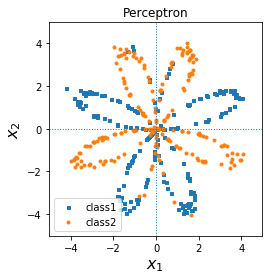

In [7]:
import joy

X, Y = joy.planar_data()            # X, Y = joy.noisy_moons()
joy.plot_xyw(X.T, Y.squeeze())
n_h = 4                            # 은닉층 노드의 수
nn = LogisticNeuron(n_h)             # 클래스 객체 nn을 생성함.
nn.fit(X, Y)                         # 입력 자료 X와 클래스 레이블 Y보내어 가중치를 구함.

### 7.4 신경망의 실행 결과의 시각화

우리는 입력자료를 모두 학습하는데 사용하였기 때문에 새로운 자료로 신경망을 테스트하거나 검증할 수 없습니다. 다만, 입력자료를 다시 신경망에 보내 얼마나 분류를 잘했는지, 그 정확도를 계산해보는 것은 상당한 의미가 있을 것입니다. 

plot_decision_regions()함수는 X 입력 자료에 대해 행$^{row}$벡터 형식의 요구하기에 때문에 X 를 전치합니다.  또한, plot_decision_regions()함수가 자체적으로 자료를 보내 예측값을 반환받을 수 있는 함수(call back function)를 요구하고 있습니다.  즉 nn.predict 메소드를 인자로 보내야 합니다.  nn.predict가 요구하는 입력자료의 형상을 맞추어 주기 익명함수를 도입하였습니다.  우리가 익명함수를 보내주었으므로, plot_decision_regions()함수는 nn.predict를 호출할 때, 익명함수가 받은 인자를 전치한 값으로 호출하게 됩니다.  

또한 계산할 수 있는 메소드(혹은 함수)의 신경망의 predict()메소드도 마찬가지  predict()함수도 마찬가지입니다. 

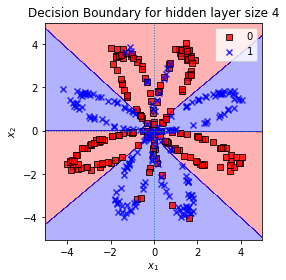

In [12]:
plt.title("Decision Boundary for hidden layer size " + str(nn.n_h))
joy.plot_decision_regions(X.T, Y, lambda z: nn.predict(z.T))

__JoyQuiz__: nn.predict(X)가 반환하는 값의 형식$^{type}$은 무엇입니까? 

__JoyQuiz__: nn.predict(X)가 반환하는 값의 형상$^{shape}$은 무엇입니까? 

### 7.5 신경망의 실행 결과의 정확도 계산

신경망의 실행 결과를 시각화하였지만, 분류의 정확도를 계산해보는 것도 필요합니다. 다음 코드는 입력 자료 X에 대한 분류의 정확도를 계산하고 출력합니다. 코드 설명이 있어야겠죠?

In [13]:
# Print accuracy
yhat = nn.predict(X)
print('Accuracy: {}%'.format(((Y * yhat).sum() + ((1 - Y) * (1 - yhat)).sum())/Y.size * 100))

Accuracy: 87.75%


각 자료에 대하여 `nn.predict()`가 반환하는 예측값이 있고, 또한 각 자료에 대한 정확한 값 즉 클래스 레이블 Y가 있습니다.  그러므로 예측의 정확도는 클래스 1을 1로 분류한 수와 클래스 0를 0로 정확하게 분류한 경우의 수를 더한 값을 전체 자료의 수로 나누면 다음과 같은 수식으로 정확도를 계산할 수 있습니다. 

\begin{align} accuracy = \frac{(good \ predictions\ for\ class\ 1) + 
  (good\ predicitions\ for\ class\ 0)}{total\ number\ of\ examples} \times 100 \end{align}

그런데, 여기서 문제는, `nn.predict()`가 반환하는 값을 `yhat`이라고 한다면, `yhat`의 값들이 `True/False` 형식이며, 반면에 Y의 값들은 1과 0로 구성되어 있다는 것입니다. 그러면, 어떻게 클래스 1을 1로 분류한 경우의 수를 계산할 수 있을까요? 

예를 들면, 다음과 같은 두 개의 Numpy 배열이 있다면,

`
 YH = [[True, True, False, False, False, True]]
 YY = [[1, 1, 1, 0, 1, 1]]
`

1을 1로 분류한 것은 3개이며, 0을 0으로 분류한 것은 1개입니다. 그러므로, 정확도는 4/6입니다. 

문제는 이것을 어떻게 코딩하느냐는 것입니다. 다행히 파이썬에서는 True는 1, False는 0로 간주하여 연산을 하기 때문에, `True * 0 = 0, True * 1 = 1, False * 1 = 0, False * 0 = 0` 입니다. 이를 코딩으로 구현하면 다음과 같습니다. 

`
(YH * YY).sum()` 혹은 `np.dot(YH, YY.T)`하면 1을 1로 분류한 경우의 수가 나옵니다. 

그러면, 0을 0으로 분류한 경우의 수는 어떻게 구할까요? 

어떤 값이든지 0 이나 False를 곱하면 0이 나오기 때문에 다른 방법을 취해야 합니다. 한 방법은 값을 반전하여 곱하고 합산하는 것입니다. 즉 `(1 - YH), (1 - YY)`은 `True/False`를 `False/True`로 반전하고, `1/0`를 `0/1`로 반전합니다. 이 두 식을 곱한 후에 합산하면, 0를 0로 분류한 경우의 수가 나오며, 이를 코딩하는 다음과 같습니다. 

`
((1 - YH) * (1 - YY)).sum()  혹은 np.dot(1 - YH, 1 - YY.T))
`

In [14]:
YH = np.array([[True, True, False, False, False, True]])
YY = np.array([[1, 1, 1, 0, 1, 1]])
print('1->1 =', (YH * YY).sum())
print('0->1 =', ((1 - YH) * (1 - YY)).sum())

1->1 = 3
0->1 = 1


In [15]:
# Print accuracy
yhat = nn.predict(X)
print('Accuracy: {}%'.format(((Y * yhat).sum() + ((1 - Y) * (1 - yhat)).sum())/Y.size * 100))
print('Accuracy: {}%'.format(float(np.dot(Y, yhat.T) + np.dot(1 - Y, 1 - yhat.T))/Y.size * 100))

Accuracy: 87.75%
Accuracy: 87.75%


### 7.6 신경망의 평균비용의 시각화

신경망을 학습하면서, 매회의 반복 학습마다 비용(평균 오차)를 저장해둔 값을 다음과 같은 간단한 코드로 시각화할 수 있습니다. 

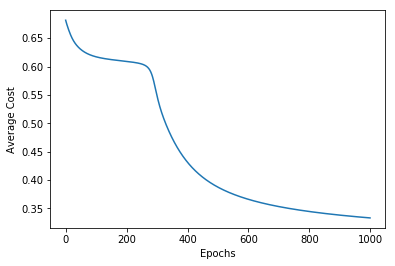

In [16]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()

### 7.7 신경망의 하이퍼파라미터$^{hyperparameter}$

기계학습에는 언제나 다루어야 할 파라미터들이 많아서 그런지 그러한 파라미터들을 가리켜 하이퍼파라미터라고 부릅니다. LogisticNeuron() 클래스에도 몇 개가 보이는데, 은닉층의 뉴론의 수 n_h, 반복 횟수 epoch, 학습률 eta 등등 입니다. 다음은 이러한 하이퍼파라미터를 조정하면서 실행한 예제입니다.  은닉층의 뉴론이 많다고 해서 항상 성능이 향상되는 것은 아니라는 것을 알 수 있습니다. 

[0] Processing 2 layers case....
[1] Processing 3 layers case....
[2] Processing 4 layers case....
[3] Processing 8 layers case....
[4] Processing 16 layers case....
[5] Processing 32 layers case....
[6] Processing 64 layers case....
[7] Processing 128 layers case....


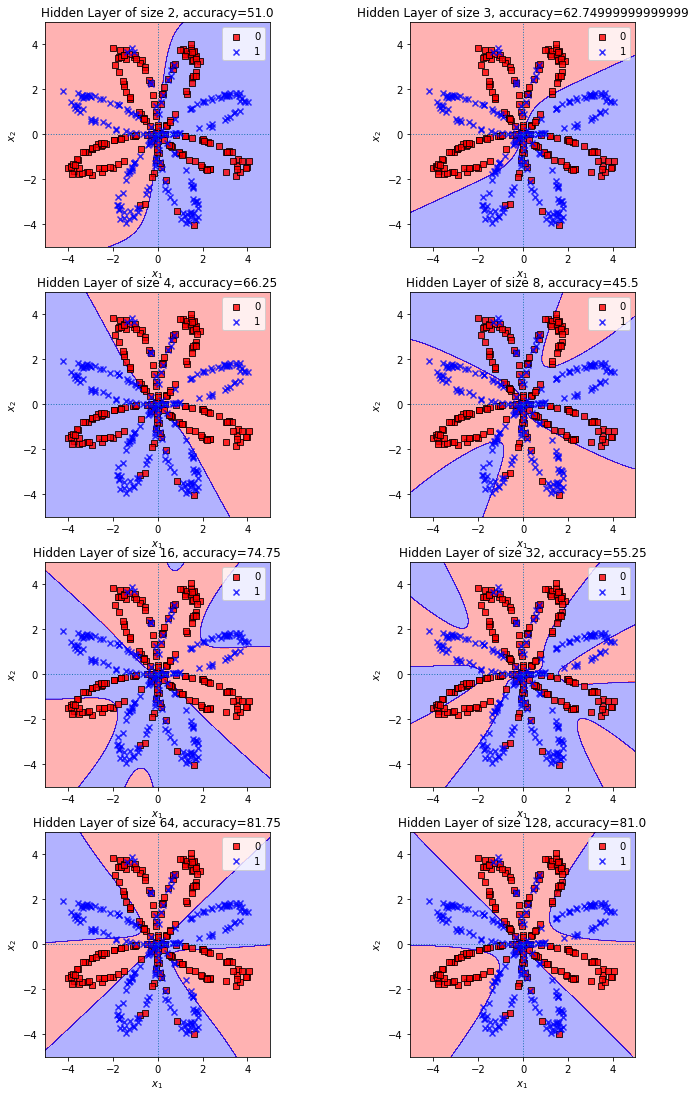

In [17]:
# This may take about 2 minutes to run
plt.figure(figsize=(12, 24))
hidden_layer_sizes = [2, 3, 4, 8, 16, 32, 64, 128]
for i, n_h in enumerate(hidden_layer_sizes):
    print('[{}] Processing {} layers case....'.format(i, n_h))
    plt.subplot(5, 2, i+1)
    nn = LogisticNeuron(n_h, eta = 0.01, epochs = 100)
    nn.fit(X, Y)
    joy.plot_decision_regions(X.T, Y, lambda x: nn.predict(x.T))
    yhat = nn.predict(X)
    accuracy = float(np.dot(Y, yhat.T) + np.dot(1 - Y, 1 - yhat.T))/Y.size * 100
    plt.title('Hidden Layer of size {}, accuracy={}'.format(n_h, accuracy))

Processing different number of neurons cases ......................................................................................................

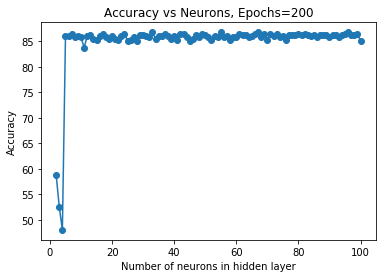

In [18]:
# This may take about 2 minutes to run
accuracy = []
number_of_neurons = [n for n in np.arange(2, 101)]
print('Processing different number of neurons cases ...', end='')
for i, n_h in enumerate(number_of_neurons):
    print('.', end='')
    nn = LogisticNeuron(n_h, eta = 0.1, epochs = 200)
    nn.fit(X, Y)
    yhat = nn.predict(X)
    accuracy.append(float(np.dot(Y, yhat.T) + np.dot(1 - Y, 1 - yhat.T))/Y.size * 100)
    
plt.title('Accuracy vs Neurons, Epochs={}'.format(nn.epochs))
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Accuracy')
plt.plot(number_of_neurons, accuracy, marker='o')

## 8. 이항 분류를 위한 자료들

사이킷런$^{scikit-learn}$에서 제공하는 다양한 자료들을 소개합니다. 우리가 위에서 공부한 로지스틱 회귀를 실험해볼 수 있는 자료들입니다. 

X.shape=(2, 200), Y.shape=(1, 200)


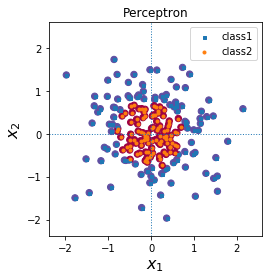

In [13]:
import joy
#X, Y = joy.noisy_circles()
#X, Y = joy.noisy_moons()
#X, Y = joy.blobs()
X, Y = joy.gaussian_quantiles()
print("X.shape={}, Y.shape={}".format(X.shape, Y.shape))

#plt.scatter(X[0, :], X[1, :], c=Y.squeeze(), s=40, cmap=plt.cm.Spectral);
joy.plot_xyw(X.T, Y.squeeze())

Text(0.5,1,'Decision Boundary for hidden layer size 4')

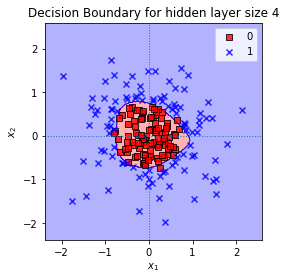

In [14]:
# Build a model with a n_h-dimensional hidden layer
nn = LogisticNeuron(4, epochs = 5000, print_cost=True)
nn.fit(X, Y)

# Plot the decision boundary
#joy.plot_decision_boundary(X, Y, lambda x: nn.predict(x.T))
joy.plot_decision_regions(X.T, Y.squeeze(), lambda x: nn.predict(x.T))
plt.title("Decision Boundary for hidden layer size " + str(nn.n_h))

### 참고자료
- https://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression
- http://bcho.tistory.com/1142
- https://www.coursera.org/learn/machine-learning/lecture/wlPeP/classification

__JoyExercise__:
1. 로지스틱 회귀에서, 입력 자료 x를 클래스 레이블 $y \in \{0, 1\}$로 이항 분류하는 가설함수 h(z)에 대한 비용함수는 다음과 같이 정의할 수 있습니다. 
\begin{align}  cost(h(z),y) = \begin{cases}
   -\log\left(h(z)\right)  \qquad \text{if y = 1}  \\
   -\log\left(1- h(z)\right) \ \ \text{if y = 0} \\
  \end{cases} 
\end{align}
다음에서 설명 중에서 맞는 것은?

(1) 만약 h(z) = y 이라고 한다면, y = 0, 또는 y = 1 일때 모두 cost(h(z), y) = 0 입니다. <br>
(2) 만약 y = 0 이라고 한다면, h(z)가 1에 수렴할수록 cost(h(z), y)의 값은 무한대로 커집니다.  <br>
(3) y = 0 혹은 y = 1 이든지 상관없이, h(z) = 0.5 이면 cost(h(z), y) = 0입니다. <br>

__JoyAnswer__: (1) & (2)

# 손실함수 도식화

In [153]:
def g(x):    # activation function
    return 1/(1 + np.exp((-x)))

def g_prime(x):  # gradient or sigmoid derivative
    return g(x) * (1 - g(x))

def cost(X, Y, W1, W2, epochs = 1):
    """ 
    X: input dataset in row vector style, 
    Y: class labels
    W1, W2: weights, its shape is (3, 1)
    """
    cost_ = []
    m = X.shape[1]

    for iter in range(epochs):
        A0 = X                        # to be consistant 
        Z1 = np.dot(W1, A0)           # hidden layer input
        A1 = g(Z1)                    # hidden layer output
        Z2 = np.dot(W2, A1)           # output layer input
        A2 = g(Z2)                    # output layer results

        E2 = Y - A2                        # error @ output
        E1 = np.dot(W2.T, E2)         # error @ hidden

        # multiply the error by the sigmoid slope at the values in Z? or A?
        dZ2 = E2 * g_prime(Z2)        # backprop      # dZ2 = E2 * A2 * (1 - A2)  
        dZ1 = E1 * g_prime(Z1)        # backprop      # dZ1 = E1 * A1 * (1 - A1)  

        W2 +=  np.dot(dZ2, A1.T)      # update output layer weights
        W1 +=  np.dot(dZ1, A0.T)      # update hidden layer weights
        cost_.append(np.sqrt(np.sum(E2 * E2)))
    return np.sum(cost_) 

<function matplotlib.pyplot.show>

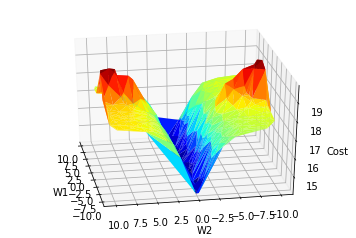

In [154]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

#X = np.array([ [0, 0, 1, 1], [0, 1, 0, 1] ])   # input dataset - col vector     
#Y = np.array([0, 1, 1, 0])                     # class labels  - for rcolvector 

X, Y = joy.planar_data()   

W1 = np.random.permutation(np.linspace(-10, 10, 500))
W2 = np.random.permutation(np.linspace(-10, 10, 500))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
zs = [cost(X, Y, w1, w2) for w1, w2 in zip(W1, W2)]
ax.plot_trisurf(W1, W2, zs, linewidth=0.02, cmap=cm.jet)
ax.azim = 170
ax.set_xlabel('W1')
ax.set_ylabel('W2')
ax.set_zlabel('Cost')
plt.show

Final prediction of all
[0 0] [0.077]
[0 1] [0.935]
[1 0] [0.94]
[1 1] [0.042]


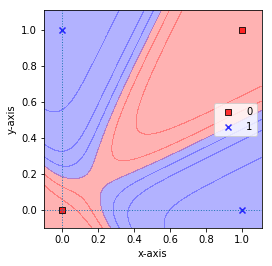

In [128]:
nn = joy.NeuralNetwork(net_arch=[2, 4, 1], epochs=10000)
X = np.array([ [0, 0, 1, 1], [0, 1, 0, 1] ])   # input dataset - col vector     
Y = np.array([0, 1, 1, 0])                     # class labels  - for rcolvector  

nn.fit(X, Y)                                         # train the net

print("Final prediction of all")
A2 = nn.predict(X.T)
for x, yhat in zip(X.T, A2.T):
    print(x, np.round(yhat, 3))

joy.plot_decision_regions(X.T, Y, nn)   
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='best')
plt.show()

## Logistic Regression:Cross entropy with SGD


## 4. 로지스틱 회귀 구현: 교차 엔트로피를 이용한 경사하강법

여기서 사용한 경사하강법은 학습자료를 하나씩 사용할 때마다 손실을 계산하여 매개변수들을 갱신하며 신경망을 학습하는 방법을 사용하였습니다. 이를 확률적(stochastic) 경사하강법이라고 하며, 이러한 경사하강법의 변형에 대해서는 11-3강에서 좀 더 자세히 다룰 예정입니다. 

In [21]:
%%writefile code/LogisticNeuron_stochastic.py
#%load code/LogisticNeuron_stochastic.py
# author: idebtor@gmail.com
# import external libraries
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np

class LogisticNeuron_stochastic(object):
    """implements Logistic Regression using cross entropy with stochastic gradient descent"""
    def __init__(self, n_x, n_h, n_y, eta = 0.2, epochs = 5, random_seed=1):
        self.n_x = n_x
        self.n_h = n_h
        
        
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        self.random_seed = random_seed
        
        np.random.seed(self.random_seed)
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1
        self.b1 = np.zeros((self.n_h, 1))
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1      
        self.b2 = np.zeros((self.n_y, 1))
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1  
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1  
        
    def CEcost(self, A2, Y):
        m = Y.shape[1]      # number of example
        logprobs = np.multiply(Y, np.log(A2))
        cost = -np.sum(logprobs)/m
        cost = np.squeeze(cost)        
        return cost  
    
    def forpass(self, A0):
        Z1 = np.dot(self.W1, A0) + self.b1         
        A1 = self.g(Z1)                          
        Z2 = np.dot(self.W2, A1) + self.b2       
        A2 = self.softmax(Z2)                   
        return Z1, A1, Z2, A2

    def fit(self, X, y): 
        self.cost_ = []
        self.m_samples = len(y)
        Y = joy.one_hot_encoding(y, self.n_y)       # (m, n_y) = (m, 10)   one-hot encoding
               
        for epoch in range(self.epochs):           
            for sample in range(self.m_samples):            
                A0 = np.array(X[sample], ndmin=2).T  
                Y0 = np.array(Y[sample], ndmin=2).T  

                Z1, A1, Z2, A2 = self.forpass(A0)          # forward pass
                
                # Cost function: Compute the cross-entropy cost
                cost = self.CEcost(A2, Y0)
                self.cost_.append(cost)
                # Backpropagation. 
                E2 = Y0 - A2                
                dZ2 = E2 
                dW2 = np.dot(dZ2, A1.T) / self.m_samples
                db2 = np.sum(dZ2, axis=1, keepdims=True) / self.m_samples
                
                E1 = np.dot(self.W2.T, E2)  
                dZ1 = E1 * self.g_prime(Z1)  #sigmoid
                #dZ1 = E1 * (1 - np.power(A1, 2)) #tanh
                dW1 = np.dot(dZ1, A0.T) 
                db1 = np.sum(dZ1, axis=1, keepdims=True) 
                
                # update weights 
                self.W1 += self.eta * dW1 
                self.b1 += self.eta * db1 
                self.W2 += self.eta * dW2 
                self.b2 += self.eta * db2 
            print('Training epoch {}/{}, cost = {}'.format(epoch+1, self.epochs, cost))
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z1, A1, Z2, A2 = self.forpass(A0)   # forpass
        return A2  

    def g(self, x):                 # activation_function: sigmoid
        x = np.clip(x, -500, 500)   # prevent from overflow, 
        return 1.0/(1.0+np.exp(-x)) # stackoverflow.com/questions/23128401/
                                    # overflow-error-in-neural-networks-implementation
    
    def g_prime(self, x):           # activation_function: sigmoid derivative
        return self.g(x) * (1 - self.g(x))
    
    def softmax(self, a):           # prevent it from overlfow and undeflow
        exp_a = np.exp(a - np.max(a))
        return exp_a / np.sum(exp_a)
    
    def evaluate(self, Xtest, ytest):   # fully vectorized calculation
        m_samples = len(ytest)  
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores = np.sum(yhat == ytest)
        return scores/m_samples * 100
        
    def evaluate_onebyone(self, Xtest, ytest):
        m_samples = len(ytest)
        scores = 0
        for m in range(m_samples):
            A2 = self.predict(Xtest[m])
            yhat = np.argmax(A2)
            if yhat == ytest[m]:
                scores += 1
        return scores/m_samples * 100

Overwriting code/LogisticNeuron_stochastic.py


## Logistic Regression:Cross entropy with SGD

## 5. 로지스틱 회귀 실행: 교차 엔트로피를 이용한 경사하강법

In [8]:
(X, y), (Xtest, ytest) = joy.load_mnist()
nn = LogisticNeuron_stochastic(784, 100, 10, 
                           eta = 0.2, epochs = 3)  
nn.fit(X, y)       
self_accuracy = nn.evaluate(X, y)
test_accuracy = nn.evaluate(Xtest, ytest)
print('self_accuracy=', self_accuracy)  # 96.265
print('test_accuracy=', test_accuracy)  # 94.94

Training epoch 1/3, cost = 0.5771204321646319
Training epoch 2/3, cost = 0.5737357698526901
Training epoch 3/3, cost = 0.5551683651406998
self_accuracy= 96.265
test_accuracy= 94.94


## KMOOC

## 6. 로지스틱 회귀 실행:  에폭의 증가에 따른 정확도 분석

### 아래 코드는 컴퓨터의 성능에 따라 다르겠지만, 일반적인 노트북의 경우 여러 시간이 걸릴 수 있습니다.
### 시간을 단축하기 위하여 에폭의 수를 아래와 같이 조정하면 됩니다.

`epoch_list = np.arange(1, 11)` 

`epoch_list = np.arange(1, 31, 3)`

In [20]:
(X, y), (Xtest, ytest) = joy.load_mnist()
self_accuracy = []
test_accuracy = []
epoch_list = np.arange(1, 31)
for e in epoch_list:
    nn = LogisticNeuron_stochastic(784, 100, 10, 
                               eta = 0.2, epochs = e)  
    nn.fit(X, y)       
    self_accuracy.append(nn.evaluate(X, y))  
    test_accuracy.append(nn.evaluate(Xtest, ytest))

Training epoch 1/1, cost = 0.6030753688254945
Training epoch 1/2, cost = 0.6030753688254945
Training epoch 2/2, cost = 0.5487202658185626
Training epoch 1/3, cost = 0.6030753688254945
Training epoch 2/3, cost = 0.5487202658185626
Training epoch 3/3, cost = 0.563116486742796
Training epoch 1/4, cost = 0.6030753688254945
Training epoch 2/4, cost = 0.5487202658185626
Training epoch 3/4, cost = 0.563116486742796
Training epoch 4/4, cost = 0.5933841742745642
Training epoch 1/5, cost = 0.6030753688254945
Training epoch 2/5, cost = 0.5487202658185626
Training epoch 3/5, cost = 0.563116486742796
Training epoch 4/5, cost = 0.5933841742745642
Training epoch 5/5, cost = 0.596503154716515
Training epoch 1/6, cost = 0.6030753688254945
Training epoch 2/6, cost = 0.5487202658185626
Training epoch 3/6, cost = 0.563116486742796
Training epoch 4/6, cost = 0.5933841742745642
Training epoch 5/6, cost = 0.596503154716515
Training epoch 6/6, cost = 0.5940594026414966
Training epoch 1/7, cost = 0.60307536882

Training epoch 6/19, cost = 0.5940594026414966
Training epoch 7/19, cost = 0.5905355121592542
Training epoch 8/19, cost = 0.5871559161396952
Training epoch 9/19, cost = 0.5931709816848818
Training epoch 10/19, cost = 0.5940829219495751
Training epoch 11/19, cost = 0.5946309954178646
Training epoch 12/19, cost = 0.5984456878566812
Training epoch 13/19, cost = 0.6032218253562172
Training epoch 14/19, cost = 0.6092515856869801
Training epoch 15/19, cost = 0.6148411181434446
Training epoch 16/19, cost = 0.620164627548576
Training epoch 17/19, cost = 0.625790101770539
Training epoch 18/19, cost = 0.6296785326355576
Training epoch 19/19, cost = 0.6335004276512722
Training epoch 1/20, cost = 0.6030753688254945
Training epoch 2/20, cost = 0.5487202658185626
Training epoch 3/20, cost = 0.563116486742796
Training epoch 4/20, cost = 0.5933841742745642
Training epoch 5/20, cost = 0.596503154716515
Training epoch 6/20, cost = 0.5940594026414966
Training epoch 7/20, cost = 0.5905355121592542
Trainin

Training epoch 25/26, cost = 0.6464409713657054
Training epoch 26/26, cost = 0.6466912936454162
Training epoch 1/27, cost = 0.6030753688254945
Training epoch 2/27, cost = 0.5487202658185626
Training epoch 3/27, cost = 0.563116486742796
Training epoch 4/27, cost = 0.5933841742745642
Training epoch 5/27, cost = 0.596503154716515
Training epoch 6/27, cost = 0.5940594026414966
Training epoch 7/27, cost = 0.5905355121592542
Training epoch 8/27, cost = 0.5871559161396952
Training epoch 9/27, cost = 0.5931709816848818
Training epoch 10/27, cost = 0.5940829219495751
Training epoch 11/27, cost = 0.5946309954178646
Training epoch 12/27, cost = 0.5984456878566812
Training epoch 13/27, cost = 0.6032218253562172
Training epoch 14/27, cost = 0.6092515856869801
Training epoch 15/27, cost = 0.6148411181434446
Training epoch 16/27, cost = 0.620164627548576
Training epoch 17/27, cost = 0.625790101770539
Training epoch 18/27, cost = 0.6296785326355576
Training epoch 19/27, cost = 0.6335004276512722
Train

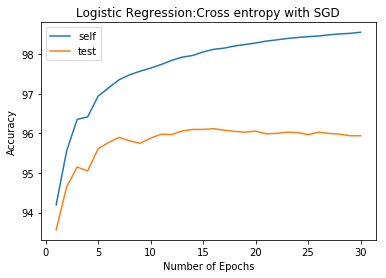

In [22]:
import matplotlib.pyplot as plt

plt.plot(epoch_list, self_accuracy, label='self')
plt.plot(epoch_list, test_accuracy, label='test')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Logistic Regression:Cross entropy with SGD')
plt.legend(loc='best')
plt.show()

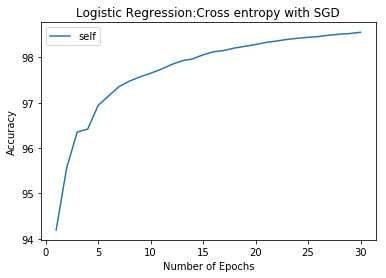

In [23]:
plt.plot(epoch_list, self_accuracy, label='self')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Logistic Regression:Cross entropy with SGD')
plt.legend(loc='best')
plt.show()

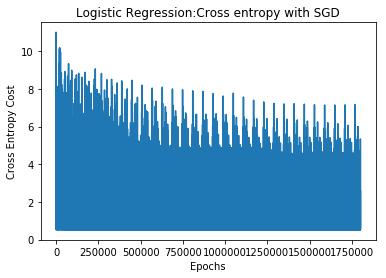

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Cost')
plt.title('Logistic Regression:Cross entropy with SGD')
plt.show()

## 학습 정리
- 로지스틱 함수 이해하기
- 로지스틱 회귀의 비용함수를 이해하기
- 로지스틱 회귀 비용함수(교차 엔트로피)를 미분하기 


-------
_Rejoice always, pray continually, give thanks in all circumstances; for this is God’s will for you in Christ Jesus. (1 Thes 5:16-18)_